# Projet 7: Implémentez un modèle de scoring (feature selection et choix du modèle de scoring)

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement des données](#load)
3. [Sélection des données d'entrainement et de test](#train_test)
4. [Feature selection](#feats)
5. [Traitement des données déséquilibrées](#imbalanced)
6. [Pipeline, optimisation et entrainement des modèles](#pipe)
7. [Choix des scores](#scores)
8. [Modélisations](#model)
    1. [Modèle Baseline: Dummy classifier](#dummy)
    2. [Régression logistique](#reglog)
    3. [LightGBM](#lightgbm)
9. [Sélection du meilleur modèle](#best)
    1. [Sauvegarde du modèle](#save)
    2. [Features importance](#feat_imp)
    3. [Définition du seuil de probabilité](#predict_proba)
    4. [Analyse du data drift](#datadrift)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [233]:
# builtin
#import os
import time
#from os import listdir

# data
import numpy as np
import pandas as pd
import random

# Fonctions personnelles
import fct_eda
import fct_preprocessing
import fct_model

# Update Fonctions personnelles
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# viz
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
import seaborn as sns

# stats
#from scipy.stats import chi2_contingency #Chi2
#import pingouin as pg # Test Chi2 d'independance

# models
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2, f_classif

# Balancing data
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipe

from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from flaml import AutoML

# Feature importance locales
from lime import lime_tabular

#import joblib # sauvegarde des modèles
#from mlflow.models.signature import infer_signature
#from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

# Enregistrement du modèle
from pickle import dump
from pickle import load


#import gc
#from contextlib import contextmanager

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

#
#from sklearn.metrics import roc_auc_score, roc_curve
#from sklearn.model_selection import KFold, StratifiedKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Configuration Pandas
pd_option_dictionary = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': None,
    'display.float_format' : '{:.2f}'.format,
}

for pat, value in pd_option_dictionary.items():
    pd.set_option(pat, value)

## Chargement des données <a class="anchor" id="load"></a>

In [38]:
df = fct_preprocessing.preprocessing_no_NaN()

Application_train shape: (307505, 64)
Processing application_train fait en 27.0s 
Bureau shape: (305811, 19)
Processing bureau et bureau_balance fait en 53.0s 
Previous applications shape: (338857, 150)
Processing previous_applications fait en 120.0s 
Pos-cash balance shape: (337252, 3)
Processing POS-CASH balance fait en 18.0s 
Installments payments shape: (339587, 4)
Processing installments payments fait en 40.0s 
Credit card balance shape: (103558, 5)
Processing credit card balance fait en 67.0s 


In [39]:
# Vérification que le dataset consolidé ne contient pas de NaN
fct_eda.shape_total_nan(df)

Nombre de lignes: 307505
Nombre de colonnes: 240
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [40]:
df.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE          NAME_EDUCATION_TYPE NAME_FAMILY_STATUS NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  FLAG_EMP_PHONE  \
SK_ID_CURR                                                                                                                                                                                                                                                                                               
100002           1         Cash loans           M            N               Y     No child         202500.00   406597.50     24700.50        351000.00   Unaccompanied   Private worker  Lower Secondary & Secondary        Not Married             Owner                        0.02               1   
100003           0         Cash loans           F            N               N     No child         270000.00  1293502.50     35698.50       1129500.00          Family    Public worker             Higher education            Married             Owner                        0.00               1   
100004           0    Revolving loans           M            Y               Y     No child          67500.00   135000.00      6750.00        135000.00   Unaccompanied   Private worker  Lower Secondary & Secondary        Not Married             Owner                        0.01               1   
100006           0         Cash loans           F            N               Y     No child         135000.00   312682.50     29686.50        297000.00   Unaccompanied   Private worker  Lower Secondary & Secondary            Married             Owner                        0.01               1   
100007           0         Cash loans           M            N               Y     No child         121500.00   513000.00     21865.50        513000.00   Unaccompanied   Private worker  Lower Secondary & Secondary        Not Married             Owner                        0.03               1   

            FLAG_WORK_PHONE  FLAG_PHONE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
SK_ID_CURR                                                                                                                                                                                                                                                              
100002                    0           1             1.00                     2                            2                       10                           0                           0                       0                       0                        0   
100003                    0           1             2.00                     1                            1                       11                           0                           0                       0                       0                        0   
100004                    1           1             1.00                     2                            2                        9                           0                           0                       0                       0                        0   
100006                    0           0             2.00                     2                            2                       17                           0                           0                       0                       0                        0   
100007                    0           0             1.00                     2                            2                       11                           0                           0                       0                       1                        1   

                                  ORGANIZATION_TYPE  EXT_SOURCE_2  OB

## Sélection des données d'entrainement et de test <a class="anchor" id="train_test"></a>

En Machine Learning il ne faut jamais valider un modèle sur les données qui ont servi à son entrainement. Le modèle doit être testé sur des données qu'il n'a jamais vues. On aura ainsi une idée de sa performance future. Le dataset sera mélangé de façon aléatoire avant d'être divisé en deux parties:
- un **train set** dont les données sont utilisées pour **entrainer le modèle**
- un **test set** réservé uniquement à **l'évaluation du modèle**

In [41]:
df_feat = df.copy()

In [42]:
# Définition des features et de la target
col_X = [f for f in df.columns if f not in ['TARGET']]
X = df_feat[col_X]
y = df_feat['TARGET']

In [43]:
# Liste des variables quantitatives
num_feat = X.select_dtypes(exclude='object').columns.tolist()   

In [44]:
# OneHotEncoder sur nos variables catégorielles
X, categ_feat = fct_eda.categories_encoder(X, nan_as_category = False)
X.head()

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\07_PROJET_7\fct_eda.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.transform(df[col])
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\07_PROJET_7\fct_eda.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.transform(df[col])
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\07_PROJET_7\fct_eda.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                                                                                                                                                                                                                                                                            
100002                       0            1             0                1         202500.00   406597.50     24700.50        351000.00                        0.02               1                0           1             1.00                     2                            2   
100003                       0            0             0                0         270000.00  1293502.50     35698.50       1129500.00                        0.00               1                0           1             2.00                     1                            1   
100004                       1            1             1                1          67500.00   135000.00      6750.00        135000.00                        0.01               1                1           1             1.00                     2                            2   
100006                       0            0             0                1         135000.00   312682.50     29686.50        297000.00                        0.01               1                0           0             2.00                     2                            2   
100007                       0            1             0                1         121500.00   513000.00     21865.50        513000.00                        0.03               1                0           0             1.00                     2                            2   

            HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                                                                                                                                                                                                                                                  
100002                           10                           0                           0                       0                       0                        0          0.26                      2.00                      2.00                0                1                0   
100003                           11                           0                           0                       0                       0                        0          0.62                      1.00                      0.00                0                1                0   
100004                            9                           0                           0                       0                       0                        0          0.56                      0.00                      0.00                0                0                0   
100006                           17                           0                           0                       0                       0                        0          0.65                      2.00                      0.00                0                1                0   
100007                           11                           0                           0                       0                       1                        1          0.32                      0.00                      0.00                0                0                0   

            FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_11

In [45]:
# Jeu d'entrainement (80%) et de validation (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)
print(f"Nb de lignes des données d'entrainement: {len(X_train)} \nNb de lignes des données de validation: {len(X_test)}")

Nb de lignes des données d'entrainement: 246004 
Nb de lignes des données de validation: 61501


In [46]:
X_train.shape

(246004, 301)

## Feature selection <a class="anchor" id="feats"></a>

Même si nous avons déjà enlevé quelques features quantitatives fortement corrélées entre elles et qualitatives en testant leur association avec la target via Chi2 et Kruskal Wallis, il reste encore beaucoup trop de variables pour les prendre toutes dans notre modèle.

La sélection des caractéristiques est le processus de réduction du nombre de variables d'entrée lors de l'élaboration d'un modèle prédictif. On trouve 2 avantages principaux à réduire le nombre de variables en entrée du modèle:
- **réduire le coût de calcul**
- **améliorer la performance du modèle**

Les méthodes basées sur les statistiques impliquent l'évaluation de la **relation entre chaque variable d'entrée et la variable cible à l'aide de statistiques**. Les variables qui ont la relation la plus forte avec la target seront conservées.

Il existe 2 techniques principales de sélection des caractéristiques: **supervisée** et **non supervisée** (les caractéristiques seront sélectionnées en fonction de la target ou non).

Les méthodes supervisées peuvent être classées en 3 groupes
- **intrinsèques**: algorithmes qui effectuent une **sélection automatique** des caractéristiques pendant l'entrainement
- **wrapper**: méthodes qui évaluent plusieurs modèles à l'aide de procédures qui **ajoutent et/ou suppriment des prédicteurs** afin de trouver la **combinaison optimale** qui **maximise la performance du modèle**.
- **filtres**: sélectionne des sous-ensembles de caractéristiques en fonction de leur **relation avec la cible**.

Nous allons dans un premier temps 
- supprimer les caractéristiques qui n'ont pas de variance c'est à dire les variables qui n'ont qu'une seule et même valeur parmis toutes les observations et n'apportent pas vraiment d'information (produit lors du OneHotEncoding)
- faire une sélection des variables catégorielles puis numériques en nous aidant de **méthodes statistiques**

### VarianceThreshold <a class="anchor" id="Variance"></a>

Nous allons ici supprimer les colonnes sans variance:

In [47]:
transform = VarianceThreshold(0)

X_train_trans = transform.fit_transform(X_train)
X_test_trans = transform.fit_transform(X_test)

In [48]:
#transform = VarianceThreshold(0)
#transform.fit_transform(X)

In [49]:
mask = transform.get_support()
feat_suppr = X.columns[~mask].tolist()

print('Colonnes supprimées')
feat_suppr

Colonnes supprimées


['PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN']

In [50]:
# Liste des variables catégorielles actualisée
categ_feat = [elem for elem in categ_feat if elem not in feat_suppr]

# Liste des variables numériques actualisée
num_feat = [elem for elem in num_feat if elem not in feat_suppr]

In [51]:
# Nouveaux df
X_train = X_train[num_feat + categ_feat]
X_test = X_test[num_feat + categ_feat]

In [52]:
X_train.shape

(246004, 299)

### SelectKBest <a class="anchor" id="SelectKBest"></a>

#### Caractéristiques qualitatives

Nous allons sélectionner les variables catégorielles grâce à la méthode statistique du **Chi2**. Nous avons déjà supprimé lors de l'analyse exploratoire les variables catégorielles sans lien avec la target mais nous allons ici mesurer la force du lien et garder les plus pertinentes via la classe **SelectKBest**.

Après avoir séparé les données en données d'entrainement et de test et transformé nos variables en numérique à l'aide du OneHotEncoder nous pouvons effectuer notre SelectKBest.

La target étant déjà au format 0 et 1, il n'y a pas besoin de la transformer. Nous afficherons les scores sur un diagramme en barres afin d'avoir une idée du nombre de features à conserver.

In [53]:
# SelectKBest
fs_categ = SelectKBest(score_func = chi2, k = 'all')
fs_categ.fit(X_train[categ_feat], y_train)

SelectKBest(k='all', score_func=<function chi2 at 0x0000020E2E429550>)

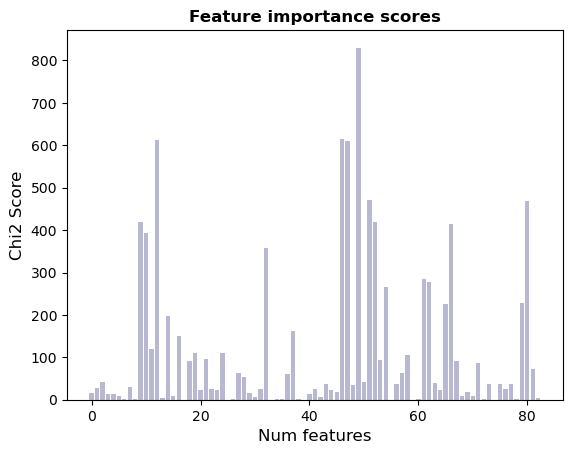

In [54]:
# Evaluation
plt.bar([i for i in range(len(fs_categ.scores_))], fs_categ.scores_, color = '#b8b8d2')
plt.xlabel("Num features", fontsize = 12)
plt.ylabel("Chi2 Score", fontsize = 12)
plt.title('Feature importance scores', fontweight = 'bold', fontsize = 12);

Nous remarquons que certaines features ont bien plus de lien avec la target. Nous allons conserver les **10 plus importantes** et **évaluer** le modèle sur les **données de test**.

Il existe de nombreuses techniques pour sélectionner les caractéristiques sur la base des résultats obtenus. Une bonne approche consiste à évaluer les modèles à l'aide de différentes méthodes de sélection de caractéristiques et de choisir la méthode qui donne le modèle le plus performant.

Pour évaluer notre choix de features, nous utiliserons un modèle de **régression logistique** avec k = 10 caractéristiques puis avec différentes valeurs de k. La régression logistique est un bon modèle pour tester les méthodes de sélection des caractéristiques car elle peut être plus performante si les caractéristiques non pertinentes sont supprimées du modèle.

In [55]:
# Pipeline + entrainement avec sélection des 10 features
fs_categ = SelectKBest(score_func = chi2, k = 10)
model = LogisticRegression(max_iter = 500, random_state=42, class_weight = 'balanced')

pipeline = Pipeline(steps=[('feat_select',fs_categ),
                           ('log_reg', model)])

pipeline.fit(X_train[categ_feat], y_train)

#X_train_fs_categ_10 = pipeline.transform(X_train[categ_feat])
#X_test_fs_categ_10 = pipeline.transform(X_test[categ_feat])

# Evaluation données de test
(biz_fs_chi2_15, beta_fs_chi2_15, rec_fs_chi2_15, prec_fs_chi2_15,
 acc_fs_chi2_15, auc_fs_chi2_15, y_pred_fs_chi2_15) = fct_model.eval_metrics(best_model = pipeline,
                                                                             xtest = X_test[categ_feat],
                                                                             ytest = y_test,
                                                                             beta_value = 2)

Score métier: 42305
Beta score: 0.32915395657635027
Recall: 0.586882623475305
Precision: 0.11940602115541091
Accuracy: 0.6144615534706753
AUC: 0.6018926391712809


Au lieu de sélectionner arbitrairement k = 10, nous allons tenter de sélectionner le meilleur nombre de features en testant différents paramètres pour k (une à toutes les colonnes catégorielles). La recherche se fera par GridsearchCV:

In [56]:
# Pipeline
fs_categ = SelectKBest(score_func = chi2, k = 'all')
model = LogisticRegression(max_iter = 500, random_state=42, class_weight = 'balanced')

pipe_fs_chi2 = Pipeline(steps=[('feat_select',fs_categ),
                               ('log_reg', model)])

In [57]:
# Méthode d'évaluation
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Optimisation du modèle
(best_model_fs_chi2, 
 best_params_fs_chi2) = fct_model.optimize_and_train_model(pipeline_model = pipe_fs_chi2,
                                                                            xtrain = X_train[categ_feat],
                                                                            ytrain = y_train,
                                                                            params = {'feat_select__k' : range(1,len(categ_feat)),},
                                                                            scoring = make_scorer(fbeta_score, beta=2),
                                                                            cv = cv)

In [58]:
best_params_fs_chi2

{'feat_select__k': 41}

In [59]:
# Evaluation sur les données de test
(biz_fs_chi2, beta_fs_chi2, rec_fs_chi2, prec_fs_chi2,
 acc_fs_chi2, auc_fs_chi2, y_pred_fs_chi2) = fct_model.eval_metrics(best_model = best_model_fs_chi2,
                                                                    xtest = X_test[categ_feat],
                                                                    ytest = y_test,
                                                                    beta_value = 2)

Score métier: 41447
Beta score: 0.33881520384546915
Recall: 0.608878224355129
Precision: 0.12213219958286539
Accuracy: 0.6123152469065544
AUC: 0.6107488466908388


D'après la grille de recherche, il semblerait qu'il faille garder les 41 variables catégorielles avec le meilleur score.

In [60]:
col_quali_keep = best_model_fs_chi2[:-1].get_feature_names_out().tolist()
col_quali_keep

['CNT_CHILDREN_One child',
 'NAME_INCOME_TYPE_Pensioner/Student/Unemployed',
 'NAME_INCOME_TYPE_Private worker',
 'NAME_INCOME_TYPE_Public worker',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Lower Secondary & Secondary',
 'NAME_FAMILY_STATUS_Not Married',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_No or low rent',
 'NAME_HOUSING_TYPE_Tenant',
 'ORGANIZATION_TYPE_Business Entity',
 'ORGANIZATION_TYPE_Electricity/Construction',
 'ORGANIZATION_TYPE_Government/Military/Security Ministries',
 'ORGANIZATION_TYPE_Other',
 'ORGANIZATION_TYPE_School/University/Kindergarten',
 'ORGANIZATION_TYPE_Self-employed',
 'CNT_FAM_MEMBERS_RANGE_2 pers',
 'AGE_RANGE_< 30 YEARS OLD',
 'AGE_RANGE_> 50 YEARS OLD',
 'YEARS_EMPLOYED_RANGE_3 years or less',
 'YEARS_EMPLOYED_RANGE_Between 3 and 8 years',
 'YEARS_EMPLOYED_RANGE_More than 8 years',
 'YEARS_EMPLOYED_RANGE_Pensioner/Unemployed',
 'YEARS_REGISTRATION_RANGE_< 6 YEARS',
 'YEARS_REGISTRATION_RANGE_> 20 YEARS',
 'YEARS_REGISTRATI

In [61]:
# Liste des variables catégorielles actualisée
categ_feat = col_quali_keep

In [62]:
# Actualisation de la liste des variables catégorielles et des df
# Nouveaux df
X_train = X_train[num_feat + categ_feat]
X_test = X_test[num_feat + categ_feat]

In [63]:
X_train.shape

(246004, 257)

#### Caractéristiques numériques

De la même manière que pour les variables catégorielles, nous allons utiliser la fonction SelectKBest de Sklearn mais sur nos variables quantitatives en utilisant la méthode Anova (f_classif). Ce test statistique permet de déterminer si les **moyennes de plusieurs échantillons de données sont identiques**.

In [64]:
# Pipeline
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_feat)],
                                 remainder='drop')
fs_num = SelectKBest(score_func = f_classif, k = 'all')
model = LogisticRegression(max_iter = 500, random_state=42, class_weight = 'balanced')

pipe_fs_anova = Pipeline(steps=[('scaler', preprocessor),
                                ('feat_select',fs_num),
                                ('log_reg', model)])

In [65]:
# Méthode d'évaluation
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Optimisation du modèle
best_model_fs_anova, best_params_fs_anova = fct_model.optimize_and_train_model(pipeline_model = pipe_fs_anova,
                                                                               xtrain = X_train[num_feat],
                                                                               ytrain = y_train,
                                                                               params = {'feat_select__k' : range(1, len(num_feat), 10),},
                                                                               scoring = make_scorer(fbeta_score, beta=2),
                                                                               cv = cv)

In [66]:
best_params_fs_anova

{'feat_select__k': 211}

In [67]:
# Tentative avec k proches du best params

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
best_model_fs_anova, best_params_fs_anova = fct_model.optimize_and_train_model(pipeline_model = pipe_fs_anova,
                                                                               xtrain = X_train[num_feat],
                                                                               ytrain = y_train,
                                                                               params = {'feat_select__k' : range(200, len(num_feat), 1),},
                                                                               scoring = make_scorer(fbeta_score, beta=2),
                                                                               cv = cv)

In [68]:
# Evaluation sur les données de test
(biz_fs_anova, beta_fs_anova, rec_fs_anova, prec_fs_anova,
 acc_fs_anova, auc_fs_anova, y_pred_fs_anova) = fct_model.eval_metrics(best_model = best_model_fs_anova,
                                                                       xtest = X_test[num_feat],
                                                                       ytest = y_test,
                                                                       beta_value = 2)

Score métier: 34736
Beta score: 0.40217285394134267
Recall: 0.6602679464107178
Precision: 0.15687951349296844
Accuracy: 0.683826279247492
AUC: 0.6730897254177483


In [69]:
best_params_fs_anova

{'feat_select__k': 203}

D'après la grille de recherche, il semblerait qu'il faille garder les 203 variables numériques avec le meilleur score:

In [70]:
col_quanti_keep = best_model_fs_anova[:-1].get_feature_names_out().tolist()
col_quanti_keep

['num__AMT_INCOME_TOTAL',
 'num__AMT_CREDIT',
 'num__AMT_ANNUITY',
 'num__AMT_GOODS_PRICE',
 'num__REGION_POPULATION_RELATIVE',
 'num__FLAG_EMP_PHONE',
 'num__FLAG_WORK_PHONE',
 'num__FLAG_PHONE',
 'num__CNT_FAM_MEMBERS',
 'num__REGION_RATING_CLIENT',
 'num__REGION_RATING_CLIENT_W_CITY',
 'num__HOUR_APPR_PROCESS_START',
 'num__REG_REGION_NOT_LIVE_REGION',
 'num__REG_REGION_NOT_WORK_REGION',
 'num__REG_CITY_NOT_LIVE_CITY',
 'num__REG_CITY_NOT_WORK_CITY',
 'num__LIVE_CITY_NOT_WORK_CITY',
 'num__EXT_SOURCE_2',
 'num__OBS_30_CNT_SOCIAL_CIRCLE',
 'num__DEF_30_CNT_SOCIAL_CIRCLE',
 'num__FLAG_DOCUMENT_2',
 'num__FLAG_DOCUMENT_3',
 'num__FLAG_DOCUMENT_6',
 'num__FLAG_DOCUMENT_8',
 'num__FLAG_DOCUMENT_9',
 'num__FLAG_DOCUMENT_11',
 'num__FLAG_DOCUMENT_13',
 'num__FLAG_DOCUMENT_14',
 'num__FLAG_DOCUMENT_15',
 'num__FLAG_DOCUMENT_16',
 'num__FLAG_DOCUMENT_18',
 'num__AGE',
 'num__YEARS_EMPLOYED',
 'num__YEARS_REGISTRATION',
 'num__YEARS_ID_PUBLISH',
 'num__YEARS_LAST_PHONE_CHANGE',
 'num__CREDIT_

In [71]:
# Liste des variables quantitatives actualisée
num_feat = [str(i).replace('num__', "") for i in col_quanti_keep]

In [72]:
# Suppression variable AGE et ajout ratios
# num_feat.remove('AGE')
# num_feat.extend(['CREDIT_DURATION', 'DEBT_RATIO', 'INCOME_PER_PERSON'])

In [73]:
# Actualisation de la liste des variables catégorielles et des df
# Nouveaux df
X_train = X_train[num_feat + categ_feat]
X_test = X_test[num_feat + categ_feat]

In [74]:
X_train.shape

(246004, 244)

In [75]:
X_train.head()

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                                                                                                                                                                                                                                                             
111778             157500.00   198085.50     23638.50        171000.00                        0.01               1                1           1             3.00                     2                            2                        7                           0                           0   
442153              67500.00   628114.50     19849.50        477000.00                        0.02               1                1           0             1.00                     2                            2                       11                           0                           0   
285544             202500.00   942300.00     27679.50        675000.00                        0.04               1                0           0             1.00                     2                            2                        9                           0                           0   
317493             270000.00   485640.00     38133.00        450000.00                        0.00               1                0           0             2.00                     2                            2                        7                           0                           0   
135529             405000.00   675000.00     30631.50        675000.00                        0.01               1                0           0             2.00                     2                            1                       11                           0                           0   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_6  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_11  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
SK_ID_CURR                                                                                                                                                                                                                                                                                         
111778                           0                       0                        0          0.49                      1.00                      0.00                0                1                0                0                0                 0                 0                 0   
442153                           0                       0                        0          0.78                      0.00                      0.00                0                1                0                0                0                 0                 0                 0   
285544                           0                       0                        0          0.68                      4.00                      0.00                0                1                0                0                0                 0                 0                 0   
317493                           0                       0                        0          0.58                      0.00                      0.00                0                0                0                1                0                 0                 0                 0   
135529                           0                       0                        0          0.72                      4.00                      0.00                0                0    

## Traitement des données déséquilibrées <a class="anchor" id="imbalanced"></a>

Lors de l'analyse exploratoire, nous avons remarqué que les données étaient très **déséquilibrées** entre les défaillants et non défaillants. Les non défaillants sont largement sur représentés (> 91%).

La plupart des modèles de Machine Learning vont **ignorer la classe minoritaire** et donc avoir des **performances médiocres** dans cette classe alors qu'en général c'est la performance de la classe minoritaire qui est la plus importante.

Une des approches pour traiter les ensembles de données déséquilibrés consiste à suréchantillonner la classe minoritaire. La méthode la plus simple est de **dupliquer les exemples de la classe minoritaire** même si aucune information n'est ajoutée au modèle.

Il est également possible de **pondérer les classes** c'est à dire ajuster la fonction de coût du modèle de manière à ce qu'une mauvaise classification d'une observation de la classe minoritaire soit plus lourdement pénalisée qu'une mauvaise classification d'une observation de la classe majoritaire. Cette approcge contribue à améliorer la précision du modèle en rééquilibrant la distribution des classes. Comme aucun nouveau point de données n'est créé, la méthode doit ête utilisée conjointement avec d'autres méthodes comme le suréchantillonnage par exemple.

Au lieu de cela, de nouveaux **exemples peuvent être synthétisés à partir des exemples existants**. Il s'agit d'un type d'augmentation de données pour la classe minoritaire appelé **SMOTE** pour (Synthetic Minority Oversampling Technique ou Technique de suréchantillonnage synthétique des minorités).

Un **exemple aléatoire de la classe minoritaire** est choisi et les k plus proches voisins sont trouvés (avec k = 5 en général). **Un voisin est choisi au hasard** et un segment est tracé entre les 2 points.
 
Il est recommandé d'utiliser d'abord un **sous-échantillonnage aléatoire** pour réduire le nombre d'exemples dans la classe minoritaire puis d'utiliser **SMOTE** pour suréchantillonner la classe minoritaire afin d'équilibrer la distribution des classes. C'est une approche efficace car les nouveaux exemples synthétiques de la classe minoritaire sont plausibles (proches dans l'espace des caractéristiques des exemples existants de la classe minoritaire).

L'inconvénient général serait que les exemples synthétiques sont créés sans tenir compte de la classe majoritaire.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

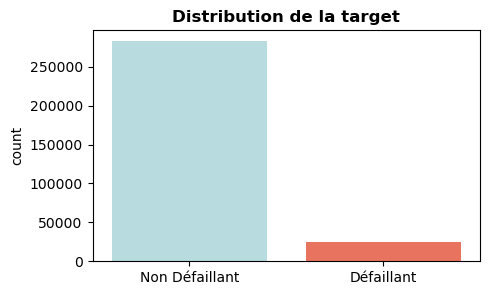

In [76]:
# Distribution de la target
plt.figure(figsize=(5,3))
sns.countplot(x = 'TARGET', data = df, palette=['powderblue', 'tomato'])
plt.title('Distribution de la target', fontweight='bold', fontsize = 12)
x = [0, 1]
plt.xticks(x, ['Non Défaillant', 'Défaillant'])
plt.xlabel('');

In [77]:
Counter(df['TARGET'])

Counter({1: 24825, 0: 282680})

## Pipeline, optimisation et entrainement des modèles <a class="anchor" id="pipe"></a>

Nous allons dans un premier temps créer une **pipeline** pour chacun de nos modèles. Cette pipeline va nous permettre d'affecter des étapes de preprocessing à nos données, c'est à dire des transformations comme le **traitement des données déséquilibrées**, la **standardisation**, et de choisir le **type de modèle**.

Cette pipeline sera ensuite intégrée dans une fonction d'optimisation et d'entrainement qui va utiliser la **validation croisée** pour tester la robustesse du modèle prédictif en répétant la procédure de split. Elle donnera plusieurs erreurs d'apprentissage et de test et donc une **estimation de la variabilité de la performance de généralisation du modèle**. 

Nous allons comparer l'erreur de validation avec l'erreur d'entrainement. On va créer un **validation set** qui va nous permettre d'optimiser les réglages du modèle qui donne les meilleures performances tout en gardant de côté les données du test set pour évaluer le modèle sur des données qu'il n'aura jamais vues.

La validation croisée peut être utilisée à la fois pour le réglage des hyperparamètres et pour l'estimation de la performance de généralisation d'un modèle. Cependant, l'utiliser à ces deux fins en même temps est problématique, car l'évaluation résultante peut sous-estimer certains overfitting résultant de la procédure de réglage des hyperparamètres elle-même. Le réglage des hyperparamètres est une forme d'apprentissage automatique et, par conséquent, nous avons besoin d'une **autre boucle externe de validation croisée pour évaluer correctement la performance de généralisation** de la procédure de modélisation complète. Lorsque l'on optimise certaines parties de la pipeline d'apprentissage automatique (par exemple, les hyperparamètres, la transformation, etc.), il est nécessaire d'utiliser la **nested cross validation** pour évaluer la performance de généralisation du modèle prédictif. Sinon, les résultats obtenus sans nested cross validation sont souvent trop optimistes. Ici, nous utiliserons la méthode KFold qui consiste à découper le train set en 10 parties, l'entrainer sur les 9 premières parties puis le valider sur la dixième. On recommencera sur toutes les configurations possibles puis on fera la moyenne des 10 scores et on pourra donc comparer nos modèles pour être sûr de prendre celui qui a en moyenne la meilleure performance

Le réglage des hyperparamètres s'effectuera soit à l'aide du  **GridSearchCV** qui va tester toutes les combinaisons possibles d'hyperparamètres afin de trouver celles qui vont minimiser le plus l'erreur (méthode exhaustive très **coûteuse en termes de puissance de calcul et de temps**), soit du **RandomizedSearchCV** qui va sélectionner des combinaisaons aléatoires d'hyperparamètres. Cette méthode est **un peu moins précise mais beaucoup plus rapide**. Elle sera utilisée pour les modèles plus complexes.

Enfin, pour évaluer la **performance réelle de nos modèles**, nous calculerons les metrics choisis sur les données de test.

## Choix des scores <a class="anchor" id="scores"></a>

Si l'on se réfère au fichier de description des colonnes:
- **1** => clients a des difficultés de paiement, il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt dans notre échantillon (**défaillant**)
- **0** => tous les autres cas (**non défaillant**)

Sur une matrice de confusion, les défaillants représentent la classe positive (Y=1) et les non défaillants la classe négative (Y=0).

Comme il serait extrêment coûteux pour la banque d'accorder un crédit à un client défaillant qui ne le rembourserait pas ou en partie, il nous faut **minimiser le nombre de faux négatifs** c'est à dire un client prédit non défaillant alors qu'il est défaillant.

Il faut également tâcher de **minimiser les faux positifs** c'est à dire prédire qu'un client est défaillant alors qu'il ne l'est pas (risque de perte de clients, de manque à gagner).

Cependant, un faux positif n'a pas le même coût qu'un faux négatif. Ce dernier est beaucoup plus coûteux pour la banque. **Nous accorderons donc 10 fois plus de poids aux faux négatifs** (fonction coût métier). 

Le **Rappel (Recall)** qui mesure le taux de vrais positifs est à favoriser au détriment de la précision qui est la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif.

Pour faire cela, nous allons nous baser sur le **F-beta score** qui est la moyenne harmonique pondérée de la précision et du rappel. Le paramètre bêta détermine le poids du rappel dans le score. Lorsqu'il est suppérieur à un, il favorise le rappel. Nous testerons plusieurs valeurs pour le beta et garderons celui qui donne le meilleur score.

Nous mettrons également l'**accuracy** et l'**AUC** comme éléments de comparaison. Le **temps d'entrainement** sera également tracké.

Le choix du meilleur modèle se fera via **cross validation sur le betascore** puis sur les données de test en fonction du **score métier et du betascore**.

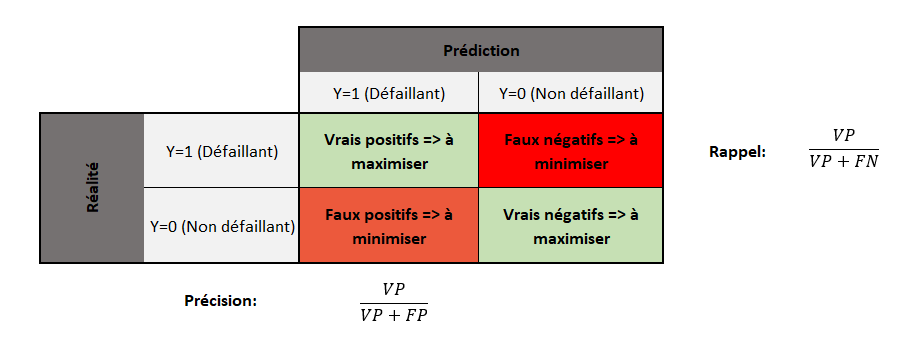

Nous allons calculer le betascore sur un modèle simple non optimisé avec différentes valeurs de beta: 

In [78]:
pipeline_beta = fct_model.pipeline_model(model = LogisticRegression(class_weight='balanced'),
                                         preprocessor = StandardScaler())
pipeline_beta.fit(X_train, y_train)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor', StandardScaler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [79]:
for b in range(1,20,1):
    y_pred = pipeline_beta.predict(X_test)
    score = fbeta_score(y_true = y_test,
                        y_pred = y_pred,
                        beta = b)
    print(f'Score avec beta = {b}: {round(score,4)}')

Score avec beta = 1: 0.2594
Score avec beta = 2: 0.4099
Score avec beta = 3: 0.5082
Score avec beta = 4: 0.5639
Score avec beta = 5: 0.5962
Score avec beta = 6: 0.616
Score avec beta = 7: 0.6288
Score avec beta = 8: 0.6375
Score avec beta = 9: 0.6437
Score avec beta = 10: 0.6482
Score avec beta = 11: 0.6516
Score avec beta = 12: 0.6542
Score avec beta = 13: 0.6563
Score avec beta = 14: 0.6579
Score avec beta = 15: 0.6593
Score avec beta = 16: 0.6604
Score avec beta = 17: 0.6613
Score avec beta = 18: 0.662
Score avec beta = 19: 0.6627


Ici le betascore atteint un pallier à partir de beta ~ 9. Nous sélectionnerons pour la suite le meilleur modèle en fonction du fbeta_score avec beta = 9

## Modélisations <a class="anchor" id="model"></a>

Nous cherchons à classer les demandes en **crédit accordé ou refusé**. Il s'agit donc d'un modèle de **classification**.

### Modèle Baseline: Dummy classifier <a class="anchor" id="dummy"></a>

Ce classificateur fait des prédictions en utilisant des règles simples. Il est utile comme **base de référence simple** à comparer avec d'autres classificateurs et ne sera pas optimisé. Il ignore les variables en entrée et par conséquent, n'utilise aucune information provenant des features. Il n'y a donc **pas besoin de transformer au préalable nos features**.

In [80]:
with mlflow.start_run():
    
    (dummy, dummy_params,
     dummy_name, dummy_duration) = fct_model.best_model(model_name = 'Baseline - Dummy classifier',
                                                        model = DummyClassifier(random_state = 42),
                                                        cv = KFold(n_splits = 5,
                                                                   shuffle = True,
                                                                   random_state = 42),
                                                        xtrain = X_train,
                                                        ytrain = y_train,
                                                        preprocessor = StandardScaler(),
                                                        params = {'classifier__strategy' : ['most_frequent','prior',
                                                                                            'stratified', 'uniform'],},
                                                        scoring = make_scorer(fbeta_score, beta=9),
                                                        xtest = X_test,
                                                        ytest = y_test,
                                                        oversampling_strategy = 0.1,
                                                        undersampling_strategy = 0.5,
                                                        balanced = False,
                                                        Randomized = False)
    
    # Evaluation sur les données de test
    (biz_dummy, beta_dummy, rec_dummy, prec_dummy,
     acc_dummy, auc_dummy, y_pred_dummy) = fct_model.eval_metrics(best_model = dummy,
                                                                  xtest = X_test,
                                                                  ytest = y_test,
                                                                  beta_value = 9)

    # log des paramètres et scores à chaque fois que le modèle est lancé
    mlflow.log_param("strategy", dummy_params)
    
    mlflow.log_metric("score metier", biz_dummy)
    mlflow.log_metric("f betascore", beta_dummy)
    mlflow.log_metric("recall", rec_dummy)
    mlflow.log_metric("precision", prec_dummy)
    mlflow.log_metric("accuracy", acc_dummy)
    mlflow.log_metric("auc", auc_dummy)
    mlflow.log_metric("Tps_entrainement", dummy_duration)
    
    mlflow.sklearn.log_model(dummy, "dummyclassifier")

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Score métier: 53949
Beta score: 0.4581636282282213
Recall: 0.4869026194761048
Precision: 0.07925400338497592
Accuracy: 0.49830084063673763
AUC: 0.4931061769946895


C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


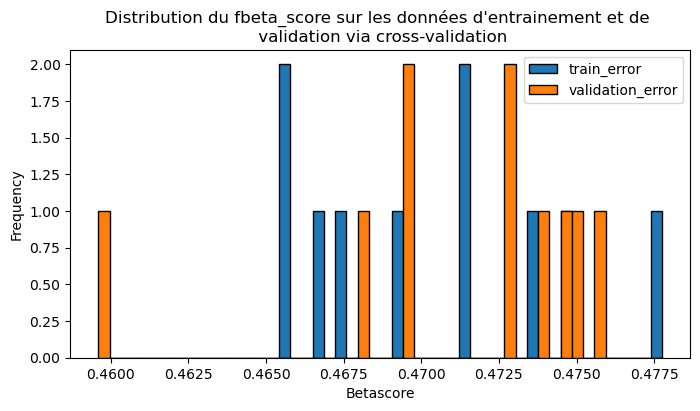

Betascore train set: 0.4703 +/- 0.0041
Betascore validation set: 0.4713 +/- 0.0048


In [81]:
fct_model.compar_train_val_scores(model = dummy, 
                                  cv = KFold(n_splits = 10, shuffle = True, random_state = 42),
                                  xtrain = X_train,
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

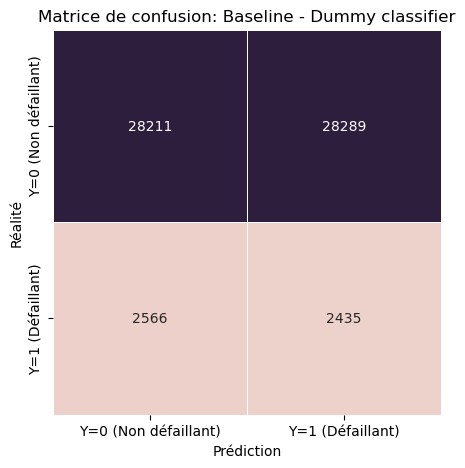

In [82]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_dummy,
                            model_name = dummy_name)

In [83]:
dic_df_recap = {'Modèle':[dummy_name],
                'Best_Params':[dummy_params],
                'Score_metier':[biz_dummy],
                'Betascore':[beta_dummy],
                'Recall':[rec_dummy], 
                'Precision':[prec_dummy], 
                'Accuracy':[acc_dummy], 
                'AUC':[auc_dummy], 
                "Train_Time": [dummy_duration],}

df_models_recap = pd.DataFrame(data = dic_df_recap)

In [84]:
df_models_recap

Modèle                          Best_Params  Score_metier  Betascore  Recall  Precision  Accuracy  AUC  Train_Time
0  Baseline - Dummy classifier  {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08      0.50 0.49       32.43

### Régression logistique <a class="anchor" id="reglog"></a>

La régression logistique est un modèle statistique qui permet d'étudier la **relation entre une variable binaire** dite variable dépendante / cible et **une ou plusieurs variables indépendantes**.

Il s'agit d'un **modèle linéaire** généralisé utilisant une fonction logistique comme fonction de lien. Il permet également de prédire la **probabilité qu'un événement arrive ou non** à partir de l'optimisation des coefficients de régression. Lorsque la valeur est > à un seuil, l'événement est susceptible de se produire alors que lorsque cette valeur est < au même seuil, il ne l'est pas. La régression logistique suppose une distribution Gaussienne des variables en entrée du modèle. Nous standardiserons donc les données mais testerons également traitement via MinMaxScaler.

Nous allons tenter d'optimiser ce modèle en jouant sur différents **preprocessings**, les **features**, le traitement du **déséquilibre des classes** et les **hyperparamètres** via **cross validation** et **GridSearch/RandomizedSearch**:
- penalty: pénalité
- solver: algorithme à utiliser pour l'optimisation
- C : force de la pénalité (valeurs plus petites => régularisation plus forte)

#### Modélisation sur données non équilibrées

In [85]:
(reglog, reglog_params,
 reglog_name, reglog_duration) = fct_model.best_model(model_name = 'Régression Logistique',
                                                      model = LogisticRegression(max_iter = 200,
                                                                                 random_state=42),
                                                      cv = KFold(n_splits = 5,
                                                                 shuffle = True,
                                                                 random_state = 42),
                                                      xtrain = X_train,
                                                      ytrain = y_train,
                                                      preprocessor = StandardScaler(),
                                                      params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
                                                                "classifier__penalty": ['l2', 'l1'],
                                                                "classifier__solver": ['lbfgs', 'saga'],
                                                                "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                      scoring = make_scorer(fbeta_score, beta=9),
                                                      xtest = X_test,
                                                      ytest = y_test,
                                                      oversampling_strategy = 0.1,
                                                      undersampling_strategy = 0.5,
                                                      balanced = False,
                                                      Randomized = False)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:4

In [86]:
reglog_params

{'preprocessor': StandardScaler(),
 'classifier__solver': 'lbfgs',
 'classifier__penalty': 'l2',
 'classifier__C': 100}

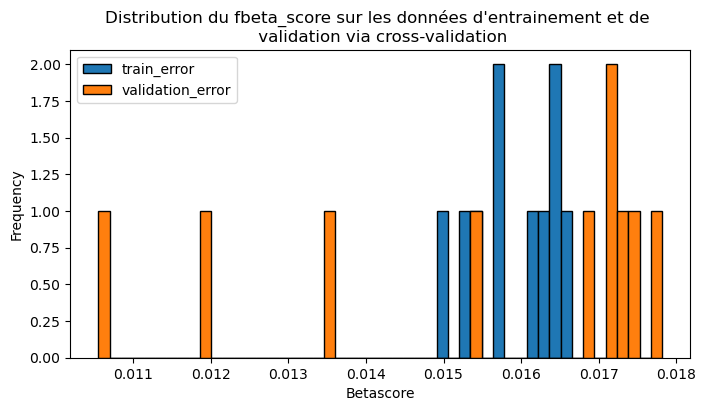

Betascore train set: 0.0159 +/- 0.0006
Betascore validation set: 0.0155 +/- 0.0026


In [87]:
fct_model.compar_train_val_scores(model = reglog, 
                                  cv = KFold(n_splits = 10, shuffle = True, random_state = 42),
                                  xtrain = X_train,
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [88]:
# Evaluation sur les données de test
(biz_reglog, beta_reglog, rec_reglog, prec_reglog,
 acc_reglog, auc_reglog, y_pred_reglog) = fct_model.eval_metrics(best_model = reglog,
                                                                 xtest = X_test,
                                                                 ytest = y_test,
                                                                 beta_value = 9)

Score métier: 49378
Beta score: 0.01436714952002566
Recall: 0.014197160567886422
Precision: 0.47651006711409394
Accuracy: 0.9185704297491097
AUC: 0.5064083147972175


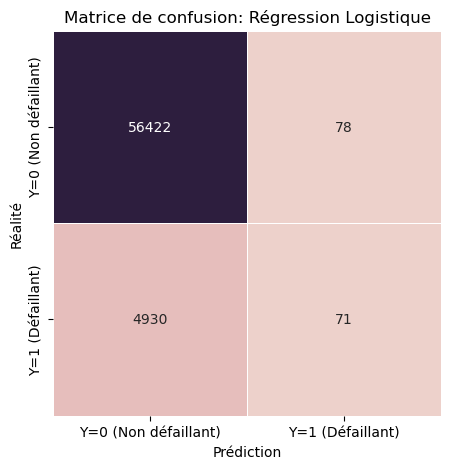

In [89]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_reglog,
                            model_name = reglog_name)

Ce modèle favorise beaucoup trop la précision au détriment du recall. Ici, il y a une relativement bonne prédiction des non défaillants mais nous cherchons à prédire correctement les défaillants. Ceci est dû au fait que la classe des non défaillants est sur représentée.

In [90]:
dic_df_recap = {'Modèle':[reglog_name],
                'Best_Params':[reglog_params],
                'Score_metier':[biz_reglog],
                'Betascore':[beta_reglog],
                'Recall':[rec_reglog], 
                'Precision':[prec_reglog], 
                'Accuracy':[acc_reglog], 
                'AUC':[auc_reglog], 
                "Train_Time": [reglog_duration],}

df_models_recap_reglog = pd.DataFrame(data = dic_df_recap)

In [91]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_reglog]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                           Best_Params  Score_metier  Betascore  Recall  Precision  Accuracy  AUC  Train_Time
0  Baseline - Dummy classifier                                                                                   {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08      0.50 0.49       32.43
1        Régression Logistique  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48      0.92 0.51     3753.28

#### Modélisation sur données rééquilibrées: pondération des classes

Chaque algorithme de classification SKlearn possède un paramètre appelé **class_weight** qui permet de gérer le déséquilibre des classes. Nous allons tester via la GridSearch avec le paramètre **'balanced'** (ajustement automatique des poids de manière inversement proportionnelle aux fréquences des classes dans les données d'entrée):

In [92]:
(reglog_cw, reglog_params_cw, 
 reglog_name_cw, reglog_duration_cw) = fct_model.best_model(model_name = 'Régression Logistique - Class Weight',
                                                            model = LogisticRegression(max_iter = 200,
                                                                                       random_state=42,
                                                                                       class_weight='balanced'),
                                                            cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                            xtrain = X_train,
                                                            ytrain = y_train,
                                                            preprocessor = StandardScaler(),
                                                            params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
                                                                      "classifier__penalty": ['l2', 'l1'],
                                                                      "classifier__solver": ['lbfgs', 'saga'],
                                                                      "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                            scoring = make_scorer(fbeta_score, beta=9),
                                                            xtest = X_test,
                                                            ytest = y_test,
                                                            oversampling_strategy = 0.1,
                                                            undersampling_strategy = 0.5,
                                                            balanced = False,
                                                            Randomized = False)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selecti

In [93]:
reglog_params_cw

{'preprocessor': StandardScaler(),
 'classifier__solver': 'saga',
 'classifier__penalty': 'l1',
 'classifier__C': 0.1}

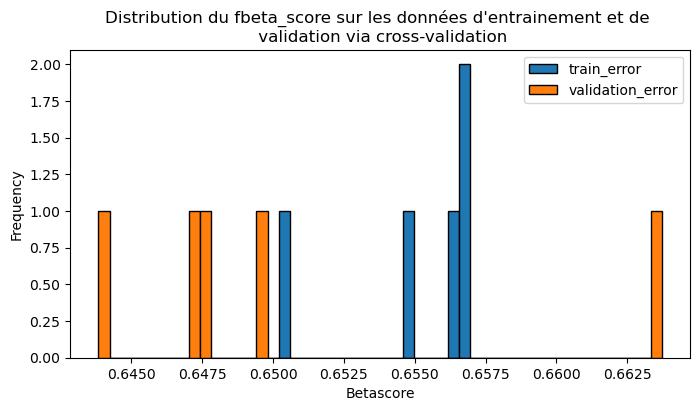

Betascore train set: 0.6551 +/- 0.0028
Betascore validation set: 0.6504 +/- 0.0077


In [94]:
fct_model.compar_train_val_scores(model = reglog_cw, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train,
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [95]:
# Evaluation sur les données de test
(biz_reglog_cw, beta_reglog_cw, rec_reglog_cw, prec_reglog_cw,
 acc_reglog_cw, auc_reglog_cw, y_pred_reglog_cw) = fct_model.eval_metrics(best_model = reglog_cw,
                                                                          xtest = X_test,
                                                                          ytest = y_test,
                                                                          beta_value = 9)

Score métier: 33977
Beta score: 0.6442865395182387
Recall: 0.6690661867626475
Precision: 0.1610744716699562
Accuracy: 0.6897286222988244
AUC: 0.6803118544432708


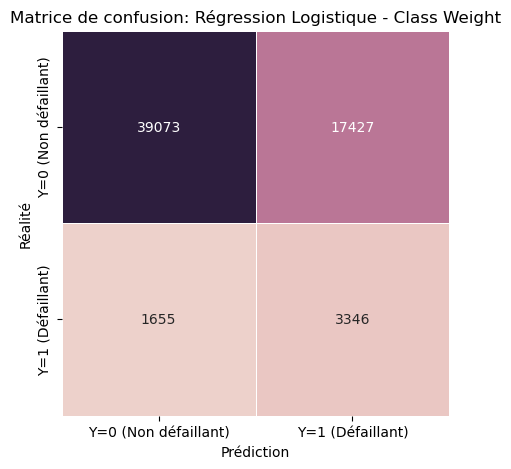

In [96]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_reglog_cw,
                            model_name = reglog_name_cw)

In [97]:
dic_df_recap = {'Modèle':[reglog_name_cw],
                'Best_Params':[reglog_params_cw],
                'Score_metier':[biz_reglog_cw],
                'Betascore':[beta_reglog_cw],
                'Recall':[rec_reglog_cw], 
                'Precision':[prec_reglog_cw], 
                'Accuracy':[acc_reglog_cw], 
                'AUC':[auc_reglog_cw], 
                "Train_Time": [reglog_duration_cw],}

df_models_recap_reglog_cw = pd.DataFrame(data = dic_df_recap)

In [98]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_reglog_cw]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                           Best_Params  Score_metier  Betascore  Recall  Precision  Accuracy  AUC  Train_Time
0           Baseline - Dummy classifier                                                                                   {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08      0.50 0.49       32.43
1                 Régression Logistique  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48      0.92 0.51     3753.28
2  Régression Logistique - Class Weight   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16      0.69 0.68     4029.51

#### Modélisation sur données rééquilibrées: sous échantillonage + SMOTE

Avec sur-échantillonnage de la classe minoritaire (10% de la classe majoritaire ~= 23000) et sous échantillonnage pour réduire la classe majoritaire (50% de plus que la classe minoritaire ~= 46000):

In [99]:
(reglog_smote1050, reglog_smote_params1050,
 reglog_smote_name1050, reglog_smote_duration1050) = fct_model.best_model(model_name = 'Régression Logistique - SMOTE 10/50',
                                                                          model = LogisticRegression(max_iter = 200, 
                                                                                                     random_state=42,),
                                                                          cv = KFold(n_splits = 5,
                                                                                     shuffle = True,
                                                                                     random_state = 42),
                                                                          xtrain = X_train,
                                                                          ytrain = y_train,
                                                                          preprocessor = StandardScaler(),
                                                                          params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
                                                                                    "classifier__penalty": ['l2', 'l1'],
                                                                                    "classifier__solver": ['lbfgs', 'saga'],
                                                                                    "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                          scoring = make_scorer(fbeta_score, beta=9),
                                                                          xtest = X_test,
                                                                          ytest = y_test,
                                                                          oversampling_strategy = 0.1,
                                                                          undersampling_strategy = 0.5,
                                                                          balanced = True,
                                                                          Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\imblearn\pipeline.py", line 2

In [100]:
reglog_smote_params1050

{'preprocessor': StandardScaler(),
 'classifier__solver': 'saga',
 'classifier__penalty': 'l2',
 'classifier__C': 1.0}

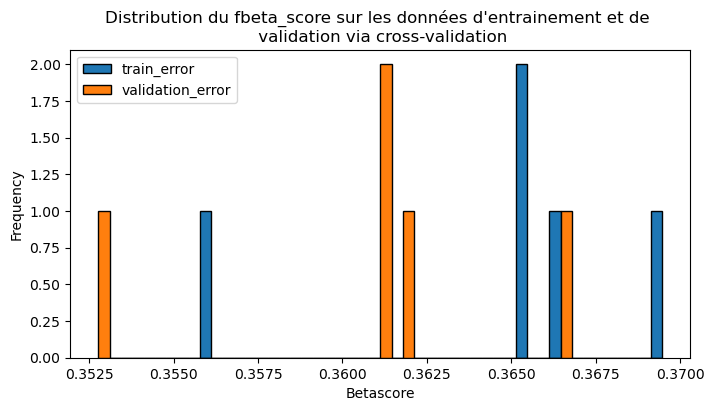

Betascore train set: 0.3645 +/- 0.0050
Betascore validation set: 0.3608 +/- 0.0050


In [101]:
fct_model.compar_train_val_scores(model = reglog_smote1050, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train,
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [102]:
# Evaluation sur les données de test
(biz_reglog_SMOTE1050, beta_reglog_SMOTE1050, rec_reglog_SMOTE1050, prec_reglog_SMOTE1050,
 acc_reglog_SMOTE1050, auc_reglog_SMOTE1050, y_pred_reglog_SMOTE1050) = fct_model.eval_metrics(best_model = reglog_smote1050,
                                                                                               xtest = X_test,
                                                                                               ytest = y_test,
                                                                                               beta_value = 9)

Score métier: 37488
Beta score: 0.36172466364017564
Recall: 0.3639272145570886
Precision: 0.24273139503867697
Accuracy: 0.8559535617307036
AUC: 0.6317158196679249


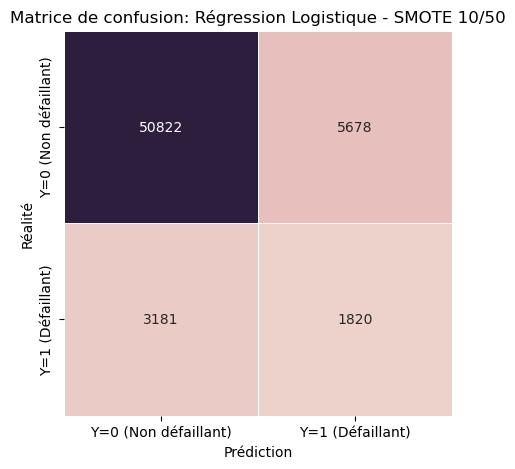

In [103]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_reglog_SMOTE1050,
                            model_name = reglog_smote_name1050)

In [104]:
dic_df_recap = {'Modèle':[reglog_smote_name1050],
                'Best_Params':[reglog_smote_params1050],
                'Score_metier':[biz_reglog_SMOTE1050],
                'Betascore':[beta_reglog_SMOTE1050],
                'Recall':[rec_reglog_SMOTE1050], 
                'Precision':[prec_reglog_SMOTE1050], 
                'Accuracy':[acc_reglog_SMOTE1050], 
                'AUC':[auc_reglog_SMOTE1050], 
                "Train_Time": [reglog_smote_duration1050],}

df_models_recap_reglog_SMOTE1050 = pd.DataFrame(data = dic_df_recap)

In [105]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_reglog_SMOTE1050]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                           Best_Params  Score_metier  Betascore  Recall  Precision  Accuracy  AUC  Train_Time
0           Baseline - Dummy classifier                                                                                   {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08      0.50 0.49       32.43
1                 Régression Logistique  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48      0.92 0.51     3753.28
2  Régression Logistique - Class Weight   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16      0.69 0.68     4029.51
3   Régression Logistique - SMOTE 10/50   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24      0.86 0.63     1537.77

Avec sur-échantillonnage de la classe minoritaire (20% de la classe majoritaire) et sous échantillonnage pour réduire la classe majoritaire (30% de plus que la classe minoritaire):

In [106]:
(reglog_smote2030, reglog_smote_params2030,
 reglog_smote_name2030, reglog_smote_duration2030) = fct_model.best_model(model_name = 'Régression Logistique - SMOTE 20/30',
                                                                          model = LogisticRegression(max_iter = 200, 
                                                                                                     random_state=42,),
                                                                          cv = KFold(n_splits = 5,
                                                                                     shuffle = True,
                                                                                     random_state = 42),
                                                                          xtrain = X_train,
                                                                          ytrain = y_train,
                                                                          preprocessor = StandardScaler(),
                                                                          params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
                                                                                    "classifier__penalty": ['l2', 'l1'],
                                                                                    "classifier__solver": ['lbfgs', 'saga'],
                                                                                    "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                          scoring = make_scorer(fbeta_score, beta=9),
                                                                          xtest = X_test,
                                                                          ytest = y_test,
                                                                          oversampling_strategy = 0.2,
                                                                          undersampling_strategy = 0.3,
                                                                          balanced = True,
                                                                          Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: C

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [107]:
reglog_smote_params2030

{'preprocessor': StandardScaler(),
 'classifier__solver': 'saga',
 'classifier__penalty': 'l1',
 'classifier__C': 100}

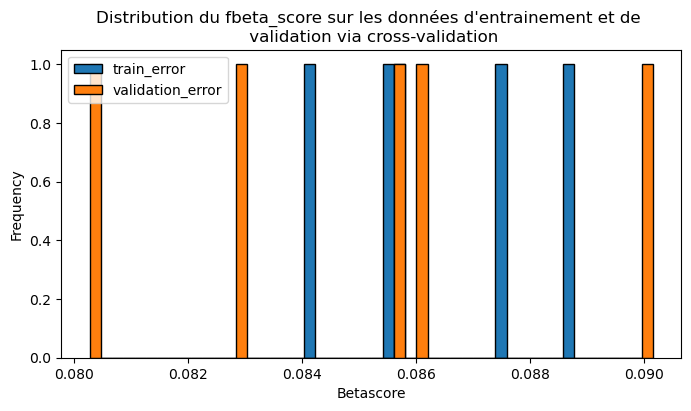

Betascore train set: 0.0863 +/- 0.0018
Betascore validation set: 0.0850 +/- 0.0037


In [108]:
fct_model.compar_train_val_scores(model = reglog_smote2030, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train,
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [109]:
# Evaluation sur les données de test
(biz_reglog_SMOTE2030, beta_reglog_SMOTE2030, rec_reglog_SMOTE2030, prec_reglog_SMOTE2030,
 acc_reglog_SMOTE2030, auc_reglog_SMOTE2030, y_pred_reglog_SMOTE2030) = fct_model.eval_metrics(best_model = reglog_smote2030,
                                                                                               xtest = X_test,
                                                                                               ytest = y_test,
                                                                                               beta_value = 9)

Score métier: 46480
Beta score: 0.08977822392150495
Recall: 0.08898220355928814
Precision: 0.326007326007326
Accuracy: 0.9109607973854084
AUC: 0.5363495088592901


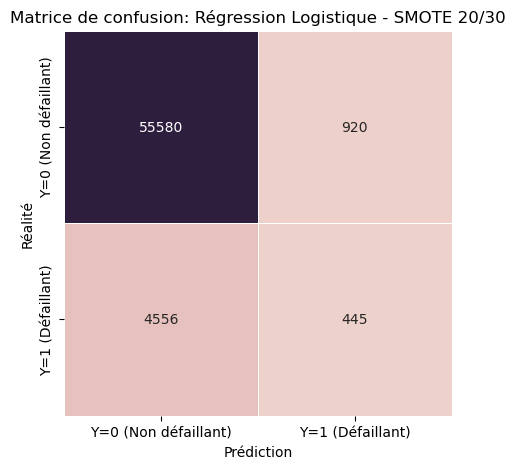

In [110]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_reglog_SMOTE2030,
                            model_name = reglog_smote_name2030)

In [111]:
dic_df_recap = {'Modèle':[reglog_smote_name2030],
                'Best_Params':[reglog_smote_params2030],
                'Score_metier':[biz_reglog_SMOTE2030],
                'Betascore':[beta_reglog_SMOTE2030],
                'Recall':[rec_reglog_SMOTE2030], 
                'Precision':[prec_reglog_SMOTE2030], 
                'Accuracy':[acc_reglog_SMOTE2030], 
                'AUC':[auc_reglog_SMOTE2030], 
                "Train_Time": [reglog_smote_duration2030],}

df_models_recap_reglog_SMOTE2030 = pd.DataFrame(data = dic_df_recap)

In [112]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_reglog_SMOTE2030]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                           Best_Params  Score_metier  Betascore  Recall  Precision  Accuracy  AUC  Train_Time
0           Baseline - Dummy classifier                                                                                   {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08      0.50 0.49       32.43
1                 Régression Logistique  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48      0.92 0.51     3753.28
2  Régression Logistique - Class Weight   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16      0.69 0.68     4029.51
3   Régression Logistique - SMOTE 10/50   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24      0.86 0.63     1537.77
4   Régression Logistique - SMOTE 20/30   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33      0.91 0.54    31617.06

In [243]:
reglog_smote_params2030['classifier__penalty']

'l1'

Avec sur-échantillonnage de la classe minoritaire (10% de la classe majoritaire) et sous échantillonnage pour réduire la classe majoritaire (60% de plus que la classe minoritaire):

In [113]:
(reglog_smote1060, reglog_smote_params1060,
 reglog_smote_name1060, reglog_smote_duration1060) = fct_model.best_model(model_name = 'Régression Logistique - SMOTE 10/60',
                                                                          model = LogisticRegression(max_iter = 200, 
                                                                                                     random_state=42,),
                                                                          cv = KFold(n_splits = 5,
                                                                                     shuffle = True,
                                                                                     random_state = 42),
                                                                          xtrain = X_train,
                                                                          ytrain = y_train,
                                                                          preprocessor = StandardScaler(),
                                                                          params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
                                                                                    "classifier__penalty": ['l2', 'l1'],
                                                                                    "classifier__solver": ['lbfgs', 'saga'],
                                                                                    "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                          scoring = make_scorer(fbeta_score, beta=9),
                                                                          xtest = X_test,
                                                                          ytest = y_test,
                                                                          oversampling_strategy = 0.1,
                                                                          undersampling_strategy = 0.6,
                                                                          balanced = True,
                                                                          Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: C

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [114]:
reglog_smote_params1060

{'preprocessor': MinMaxScaler(),
 'classifier__solver': 'saga',
 'classifier__penalty': 'l1',
 'classifier__C': 100}

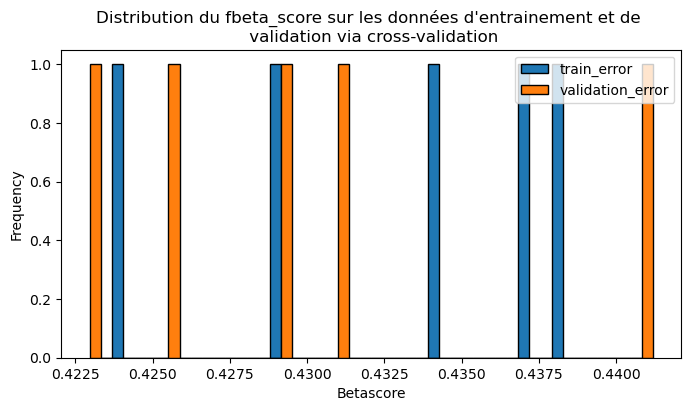

Betascore train set: 0.4324 +/- 0.0060
Betascore validation set: 0.4301 +/- 0.0070


In [115]:
fct_model.compar_train_val_scores(model = reglog_smote1060, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train,
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [116]:
# Evaluation sur les données de test
(biz_reglog_SMOTE1060, beta_reglog_SMOTE1060, rec_reglog_SMOTE1060, prec_reglog_SMOTE1060,
 acc_reglog_SMOTE1060, auc_reglog_SMOTE1060, y_pred_reglog_SMOTE1060) = fct_model.eval_metrics(best_model = reglog_smote1060,
                                                                                               xtest = X_test,
                                                                                               ytest = y_test,
                                                                                               beta_value = 9)

Score métier: 36042
Beta score: 0.4276710763839516
Recall: 0.4327134573085383
Precision: 0.22000813338755593
Accuracy: 0.8291247296791923
AUC: 0.6484629233445346


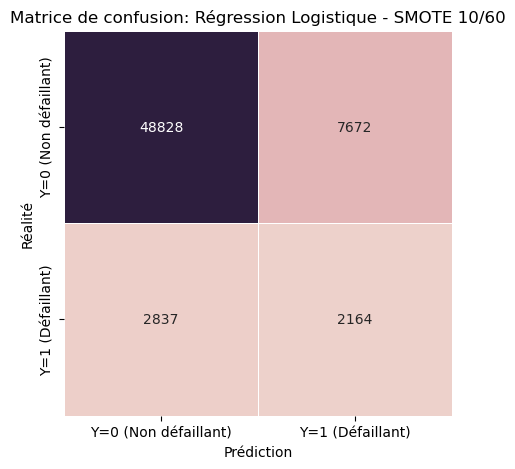

In [117]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_reglog_SMOTE1060,
                            model_name = reglog_smote_name1060)

In [118]:
dic_df_recap = {'Modèle':[reglog_smote_name1060],
                'Best_Params':[reglog_smote_params1060],
                'Score_metier':[biz_reglog_SMOTE1060],
                'Betascore':[beta_reglog_SMOTE1060],
                'Recall':[rec_reglog_SMOTE1060], 
                'Precision':[prec_reglog_SMOTE1060], 
                'Accuracy':[acc_reglog_SMOTE1060], 
                'AUC':[auc_reglog_SMOTE1060], 
                "Train_Time": [reglog_smote_duration1060],}

df_models_recap_reglog_SMOTE1060 = pd.DataFrame(data = dic_df_recap)

In [119]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_reglog_SMOTE1060]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                           Best_Params  Score_metier  Betascore  Recall  Precision  Accuracy  AUC  Train_Time
0           Baseline - Dummy classifier                                                                                   {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08      0.50 0.49       32.43
1                 Régression Logistique  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48      0.92 0.51     3753.28
2  Régression Logistique - Class Weight   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16      0.69 0.68     4029.51
3   Régression Logistique - SMOTE 10/50   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24      0.86 0.63     1537.77
4   Régression Logistique - SMOTE 20/30   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33      0.91 0.54    31617.06
5   Régression Logistique - SMOTE 10/60     {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22      0.83 0.65     1592.45

Le choix du traitement du déséquilibre des classes par class weight balanced donnant les meilleurs résultats, nous partirons de cette méthode pour le prochain modèle: le LightGBM.

#### Features importance globales

Visualiser l'importance des features permet de mieux comprendre quelles sont les **features en entrée** du modèle qui ont le **plus d'utilité dans la prédiction de la variable cible**.

Il existe de nombreux types de scores de feature importance mais les plus courants sont les scores de corrélation statistique, les coefficients dans les modèles linéaires, arbres de décision et scores d'importance par permutation.

Dans un modèle de prédiction, l'importance de features permet d'avoir une **meilleure compréhension des données et du modèle**  et offre une base pour la **réduction de dimension**, permettant la sélection de caractéristiques qui peuvent améliorer notre modèle.

Les résultats peuvent être interprétés par un expert du domaine et servir de base à la collecte de données supplémentaires ou différentes.

Les algorithmes linéaires pondèrent les valeurs d'entrée à l'aide de **coefficients** qui peuvent être utilisés comme score de feature importance.

Nous allons partir du modèle de régression logistiques ayant généré le meilleur score (régression logistique avec paramètre class weight = balanced") pour visualiser à l'aide d'un diagramme en barres l'importance des features. Nous en déduirons quelles sont les features qui aident le mieux à la prédiction et referons tourner notre modèle uniquement avec les features les plus importantes.

In [120]:
# Dataframe
feats_reglog_cw = X_train.columns
coef_reglog_cw = reglog_cw.named_steps['classifier'].coef_.ravel()

dic_reglog_cw = {'Features': feats_reglog_cw,
                 'Score': abs(coef_reglog_cw),}
df_reglog_cw = pd.DataFrame(data = dic_reglog_cw)
df_reglog_cw = df_reglog_cw.sort_values(by='Score', ascending = False)

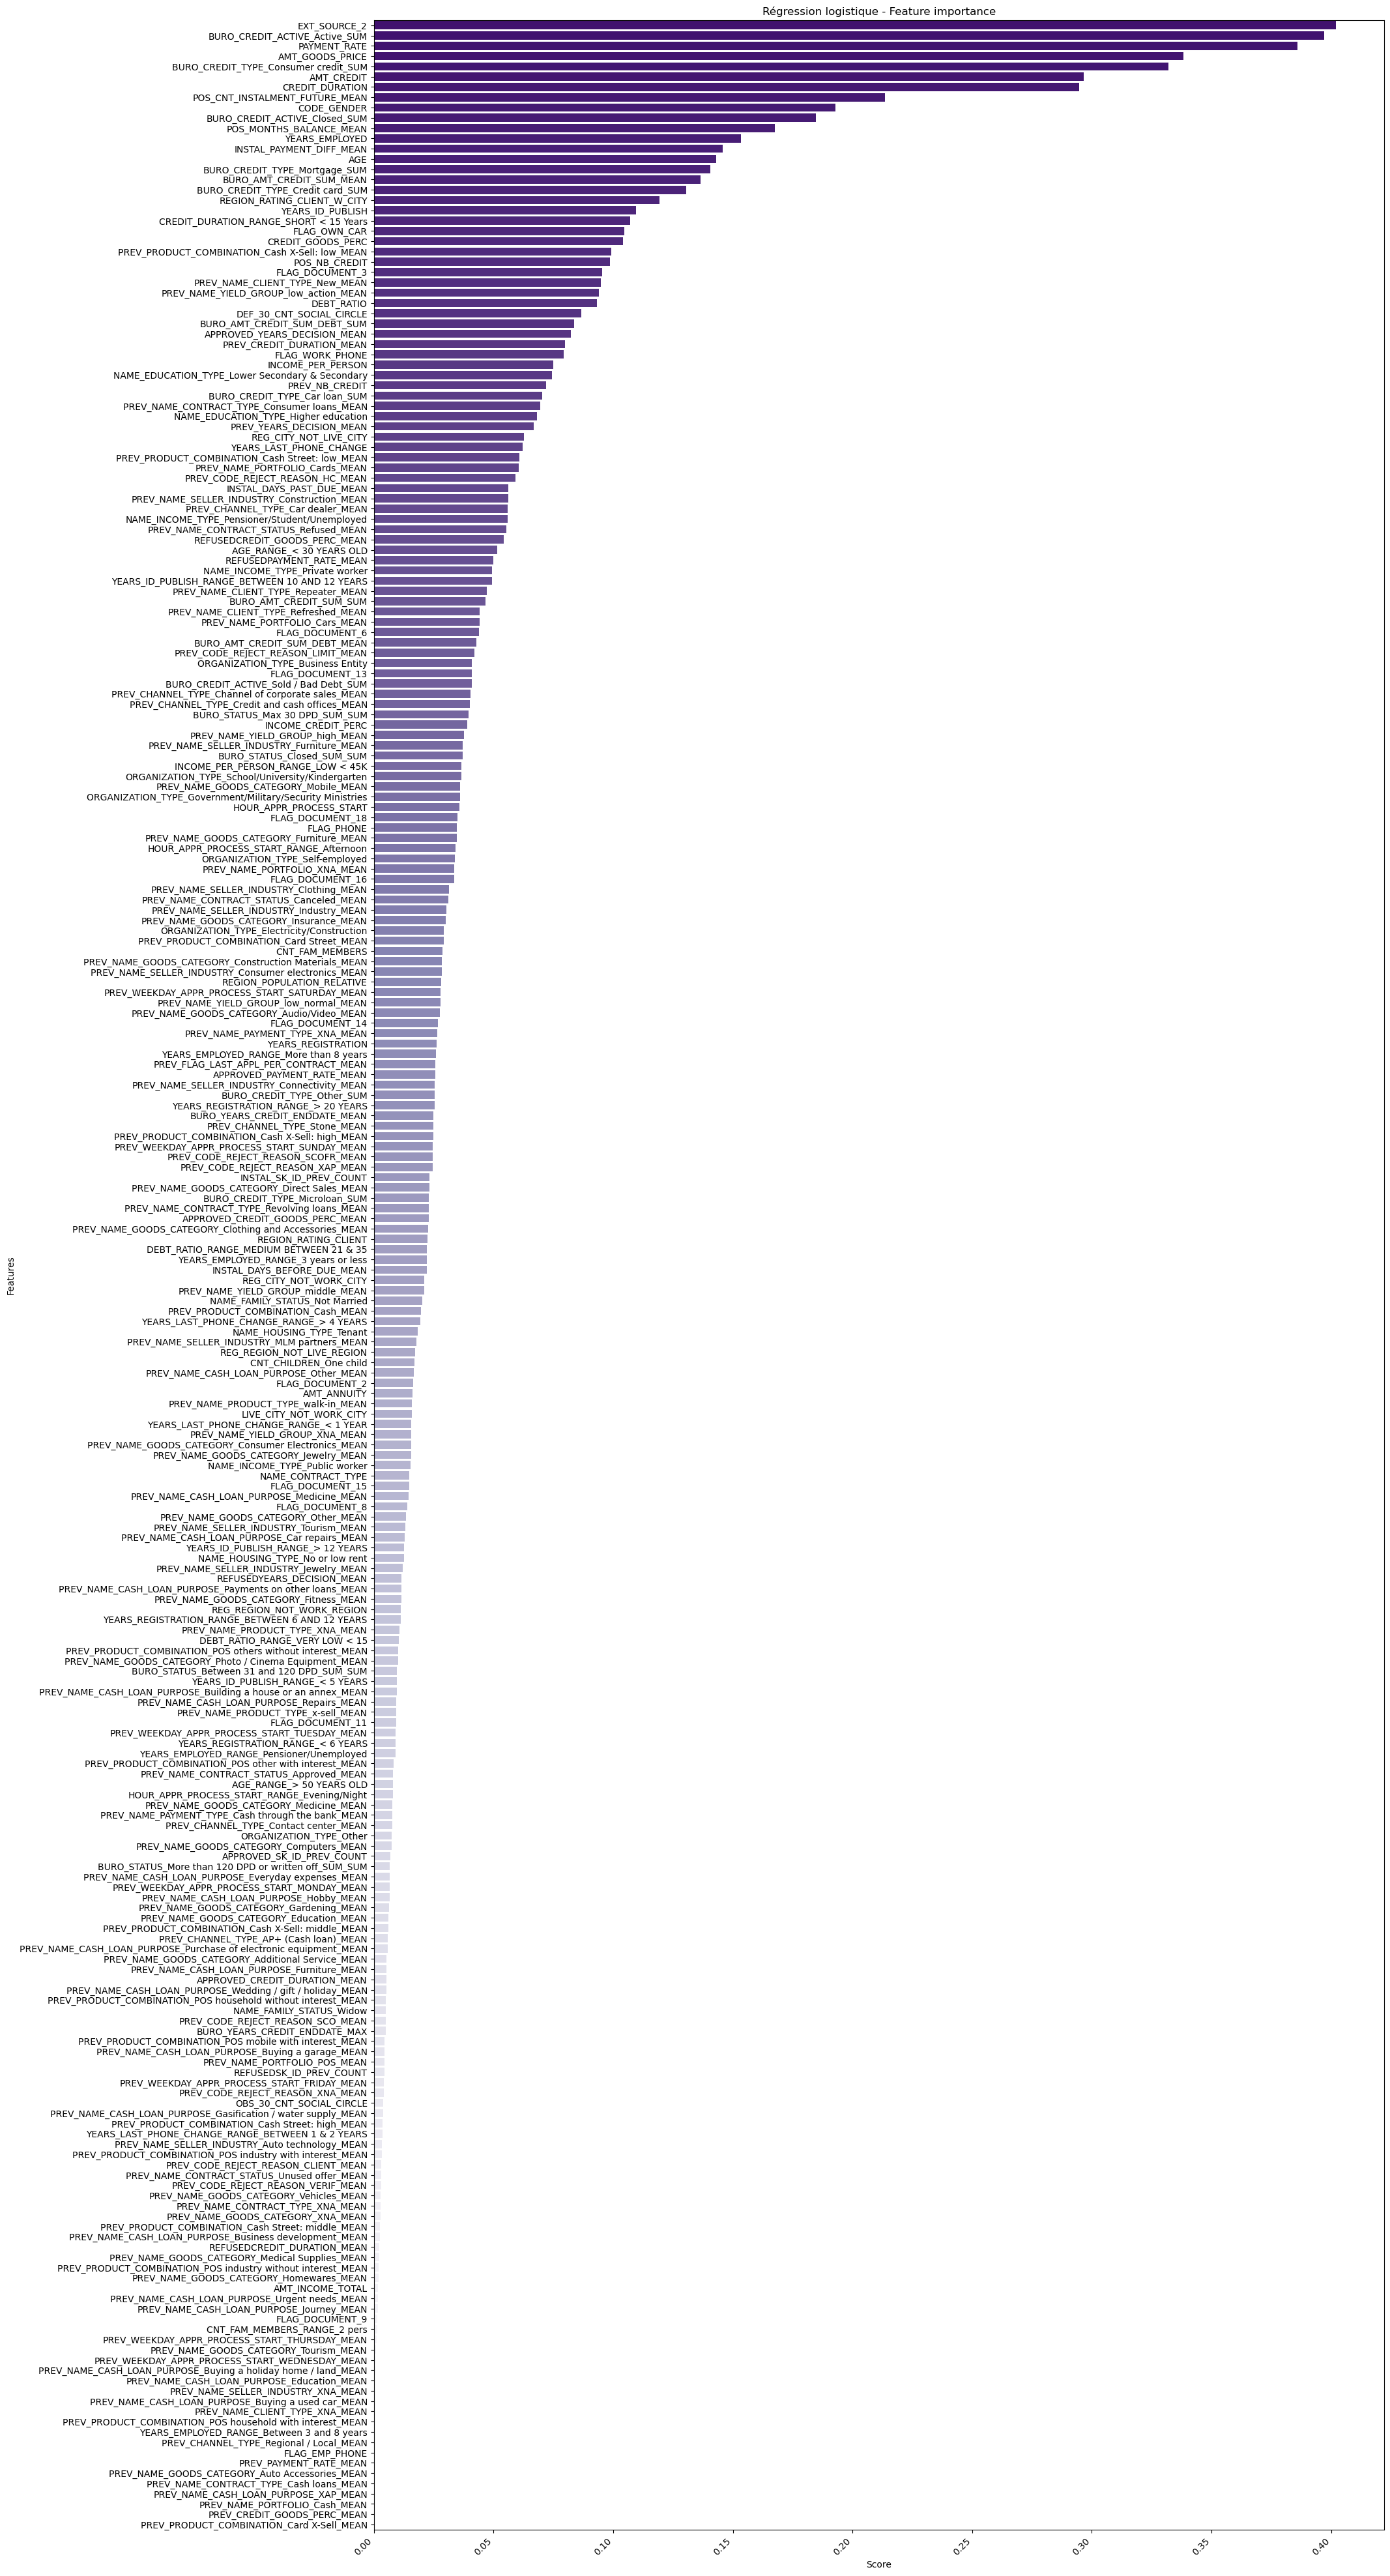

In [124]:
plt.figure(figsize=(20,50))
plt.title('Régression logistique - Feature importance')
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df_reglog_cw, x = 'Score', y = 'Features', palette='Purples_r');

Nous allons conserver les 10 features les plus importantes et refaire tourner le modèle:

In [125]:
feat_reglog_fs = df_reglog_cw[0:10]['Features'].tolist()

In [126]:
(reglog_cw_fs, reglog_params_cw_fs, 
 reglog_name_cw_fs, reglog_duration_cw_fs) = fct_model.best_model(model_name = 'Régression Logistique - CW - FS',
                                                                  model = LogisticRegression(max_iter = 200,
                                                                                             random_state=42,
                                                                                             class_weight='balanced'),
                                                                  cv = KFold(n_splits = 5,
                                                                             shuffle = True,
                                                                             random_state = 42),
                                                                  xtrain = X_train[feat_reglog_fs],
                                                                  ytrain = y_train,
                                                                  preprocessor = StandardScaler(),
                                                                  params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
                                                                            "classifier__penalty": ['l2', 'l1'],
                                                                            "classifier__solver": ['lbfgs', 'saga'],
                                                                            "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                  scoring = make_scorer(fbeta_score, beta=9),
                                                                  xtest = X_test[feat_reglog_fs],
                                                                  ytest = y_test,
                                                                  oversampling_strategy = 0.1,
                                                                  undersampling_strategy = 0.5,
                                                                  balanced = False,
                                                                  Randomized = False)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
  

In [127]:
reglog_params_cw_fs

{'preprocessor': StandardScaler(),
 'classifier__solver': 'lbfgs',
 'classifier__penalty': 'l2',
 'classifier__C': 1.0}

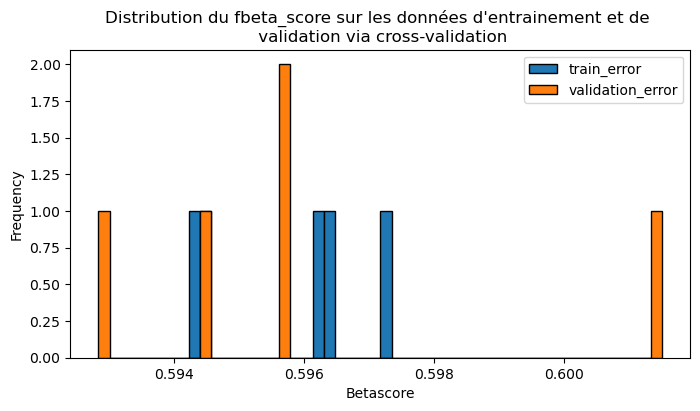

Betascore train set: 0.5957 +/- 0.0013
Betascore validation set: 0.5960 +/- 0.0033


In [128]:
fct_model.compar_train_val_scores(model = reglog_cw_fs, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train[feat_reglog_fs],
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [129]:
# Evaluation sur les données de test
(biz_reglog_cw_fs, beta_reglog_cw_fs, rec_reglog_cw_fs, prec_reglog_cw_fs,
 acc_reglog_cw_fs, auc_reglog_cw_fs, y_pred_reglog_cw_fs) = fct_model.eval_metrics(best_model = reglog_cw_fs,
                                                                                   xtest = X_test[feat_reglog_fs],
                                                                                   ytest = y_test,
                                                                                   beta_value = 9)

Score métier: 38147
Beta score: 0.5883333997015772
Recall: 0.6124775044991002
Precision: 0.14031149793861658
Accuracy: 0.663338807499065
AUC: 0.640159106231851


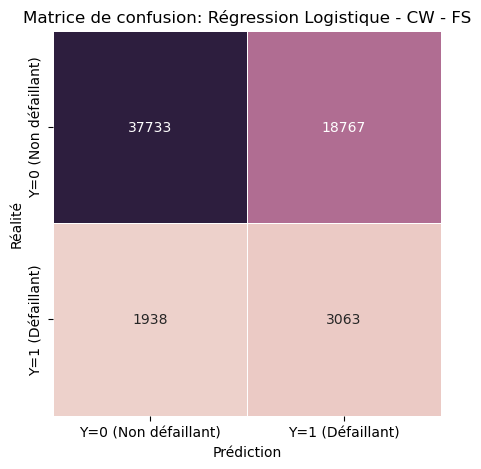

In [130]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_reglog_cw_fs,
                            model_name = reglog_name_cw_fs)

In [131]:
dic_df_recap = {'Modèle':[reglog_name_cw_fs],
                'Best_Params':[reglog_params_cw_fs],
                'Score_metier':[biz_reglog_cw_fs],
                'Betascore':[beta_reglog_cw_fs],
                'Recall':[rec_reglog_cw_fs], 
                'Precision':[prec_reglog_cw_fs], 
                'Accuracy':[acc_reglog_cw_fs], 
                'AUC':[auc_reglog_cw_fs], 
                "Train_Time": [reglog_duration_cw_fs],}

df_models_recap_reglog_cw_fs = pd.DataFrame(data = dic_df_recap)

In [132]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_reglog_cw_fs]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                           Best_Params  Score_metier  Betascore  Recall  Precision  Accuracy  AUC  Train_Time
0           Baseline - Dummy classifier                                                                                   {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08      0.50 0.49       32.43
1                 Régression Logistique  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48      0.92 0.51     3753.28
2  Régression Logistique - Class Weight   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16      0.69 0.68     4029.51
3   Régression Logistique - SMOTE 10/50   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24      0.86 0.63     1537.77
4   Régression Logistique - SMOTE 20/30   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33      0.91 0.54    31617.06
5   Régression Logistique - SMOTE 10/60     {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22      0.83 0.65     1592.45
6       Régression Logistique - CW - FS  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14      0.66 0.64       40.80

Ici, une sélection de features via feature importance plus parcimonieuse a dégradé les performances de notre modèle. Le meilleur modèle reste pour le moment la régression logistique avec les features issues de la partie feature selection et le paramètre class weight balanced.

### LightGBM <a class="anchor" id="lightgbm"></a>

Basé sur des algorithmes **d’arbre de décision**, LightGBM (Light Gradient Boosting Machine) est utilisé pour le classement, la classification et de nombreuses autres tâches de Machine Learning. C'est un algorithme développé par Microsoft et publié en 2016 qui est basé sur le **renforcement de gradient** (Gradient Boosting). 

L'objectif est de former plusieurs modèles utilisant le même algorithme d'apprentissage. Une **combinaison de modèles individuels simples** crée un **modèle plus fort et puissant**.

- Création d'un **modèle simple** qui est entrainé sur les données.
- Un **second modèle** est construit pour tenter de **corriger les erreurs** présentes dans le premier modèle. Les erreurs sont minimisées par l’algorithme de descente de gradient. Chaque arbre ajouté va compenser les erreurs commises précédemment **sans détériorer les prédictions qui ont été justes**. La base d'apprentissage estdifférente.
- Cette procédure se poursuit et des modèles sont ajoutés jusqu’à ce que l’ensemble complet des données de formation soit prédit correctement ou que le nombre maximal de modèles soit ajouté.
- Les prédictions du dernier modèle ajouté seront les prédictions globales fournies par les anciens modèles d’arbres.

https://blent.ai/blog/a/lightgbm-mieux-que-xgboost

Cet algorithme offre de très bonnes performances et nous permettra d'analyser l'importance des variables globales.

Lors de l'optimisation des hyperparamètres, nous tenterons un approche par GridSearchCV sur les hyperparamètres suivants:
- **n_estimators** = nombre d'arbres de décision (il est préférable d'en avoir plusieurs)
- **max_depth** = profondeur de chaque arbre qui contrôle le degré de spécialisation de chaque arbre par rapport à l'ensemble des données d'apprentissage (viser une profondeur modeste). Il existe deux façons principales de **contrôler la complexité des arbres** : la **profondeur maximale** des arbres et le **nombre maximal des feuilles** dans l'arbre.
- **learning_rate**: importance de la contribution de chaque modèle à la prédiction de l'ensemble (taux plus faibles => plus d'arbres de décision)

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

#### Modélisation sur données rééquilibrées par class weight + hyperparameters tuning

In [133]:
params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
          "classifier__ n_estimators": [10, 50, 100, 500, 1000, 5000],
          "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
          "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
          "classifier__ boosting_type": ['gbdt', 'dart', 'rf’'],}

lgb, lgb_params, lgb_name, lgb_duration = fct_model.best_model(model_name = 'LightGBM',
                                                               model = LGBMClassifier(random_state = 42,
                                                                                      class_weight='balanced'),
                                                               cv = KFold(n_splits = 5, 
                                                                          shuffle = True, 
                                                                          random_state = 42),
                                                               xtrain = X_train,
                                                               ytrain = y_train,
                                                               preprocessor = StandardScaler(),
                                                               params = params,
                                                               scoring = make_scorer(fbeta_score, beta=9),
                                                               xtest = X_test,
                                                               ytest = y_test,
                                                               oversampling_strategy = 0.1,
                                                               undersampling_strategy = 0.5,
                                                               balanced = False,
                                                               Randomized = True)

[LightGBM] [Warning] num_leaves is set=31, num_leaves=128 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=10 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=128 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [W

[LightGBM] [Warning] num_leaves is set=31, num_leaves=512 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=6 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.0001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=5000 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=512 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=6 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.0001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightG

[LightGBM] [Warning] num_leaves is set=31, num_leaves=1024 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=1000 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=1024 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM

[LightGBM] [Warning] num_leaves is set=31, num_leaves=4 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=1 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.0001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=5000 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=4 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=1 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.0001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM

In [134]:
lgb_params

{'preprocessor': StandardScaler(),
 'classifier__ num_leaves': 1024,
 'classifier__ n_estimators': 1000,
 'classifier__ max_depth': 2,
 'classifier__ learning_rate': 0.1,
 'classifier__ boosting_type': 'dart'}

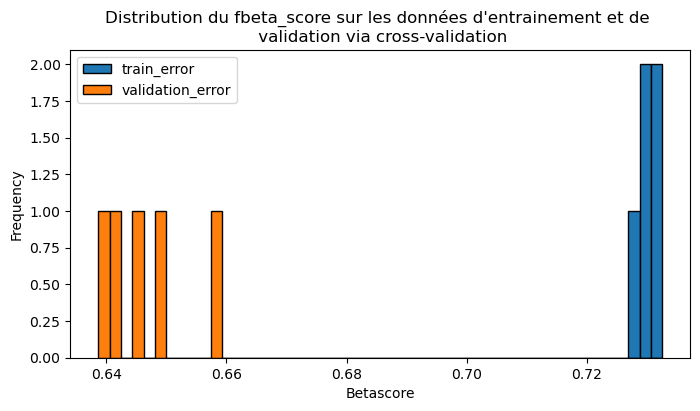

Betascore train set: 0.7305 +/- 0.0017
Betascore validation set: 0.6467 +/- 0.0078


In [135]:
fct_model.compar_train_val_scores(model = lgb, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train,
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [136]:
# Evaluation sur les données de test
(biz_lgb, beta_lgb, rec_lgb, prec_lgb,
 acc_lgb, auc_lgb, y_pred_lgb) = fct_model.eval_metrics(best_model = lgb,
                                                        xtest = X_test,
                                                        ytest = y_test,
                                                        beta_value = 9)

Score métier: 32546
Beta score: 0.6459294516835928
Recall: 0.6684663067386523
Precision: 0.17313170024340982
Accuracy: 0.7134355538934326
AUC: 0.692941117971096


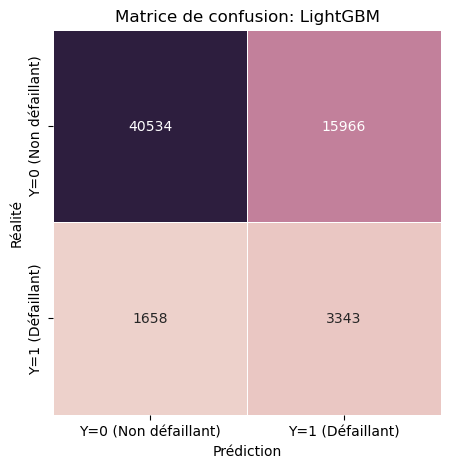

In [137]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb,
                            model_name = lgb_name)

In [138]:
dic_df_recap = {'Modèle':[lgb_name],
                'Best_Params':[lgb_params],
                'Score_metier':[biz_lgb],
                'Betascore':[beta_lgb],
                'Recall':[rec_lgb], 
                'Precision':[prec_lgb], 
                'Accuracy':[acc_lgb], 
                'AUC':[auc_lgb], 
                "Train_Time": [lgb_duration],}

df_models_recap_lgb = pd.DataFrame(data = dic_df_recap)

In [139]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                   Best_Params  Score_metier  Betascore  Recall  Precision  \
0           Baseline - Dummy classifier                                                                                                                                                                           {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08   
1                 Régression Logistique                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48   
2  Régression Logistique - Class Weight                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16   
3   Régression Logistique - SMOTE 10/50                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24   
4   Régression Logistique - SMOTE 20/30                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33   
5   Régression Logistique - SMOTE 10/60                                                                                             {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22   
6       Régression Logistique - CW - FS                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14   
7                              LightGBM  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65    0.67       0.17   

   Accuracy  AUC  Train_Time  
0      0.50 0.49       32.43  
1      0.92 0.51     3753.28  
2      0.69 0.68     4029.51  
3      0.86 0.63     1537.77  
4      0.91 0.54    31617.06  
5      0.83 0.65     1592.45  
6      0.66 0.64       40.80  
7      0.71 0.69      476.24

#### Avec sélection de Features via Features importance

In [140]:
# Dataframe
feats_lgb = X_train.columns
feat_imp_lgb = lgb.named_steps['classifier'].feature_importances_

dic_lgb = {'Features': feats_lgb,
           'Score': feat_imp_lgb}
df_lgb = pd.DataFrame(data = dic_lgb)
df_lgb = df_lgb.sort_values(by='Score', ascending = False)

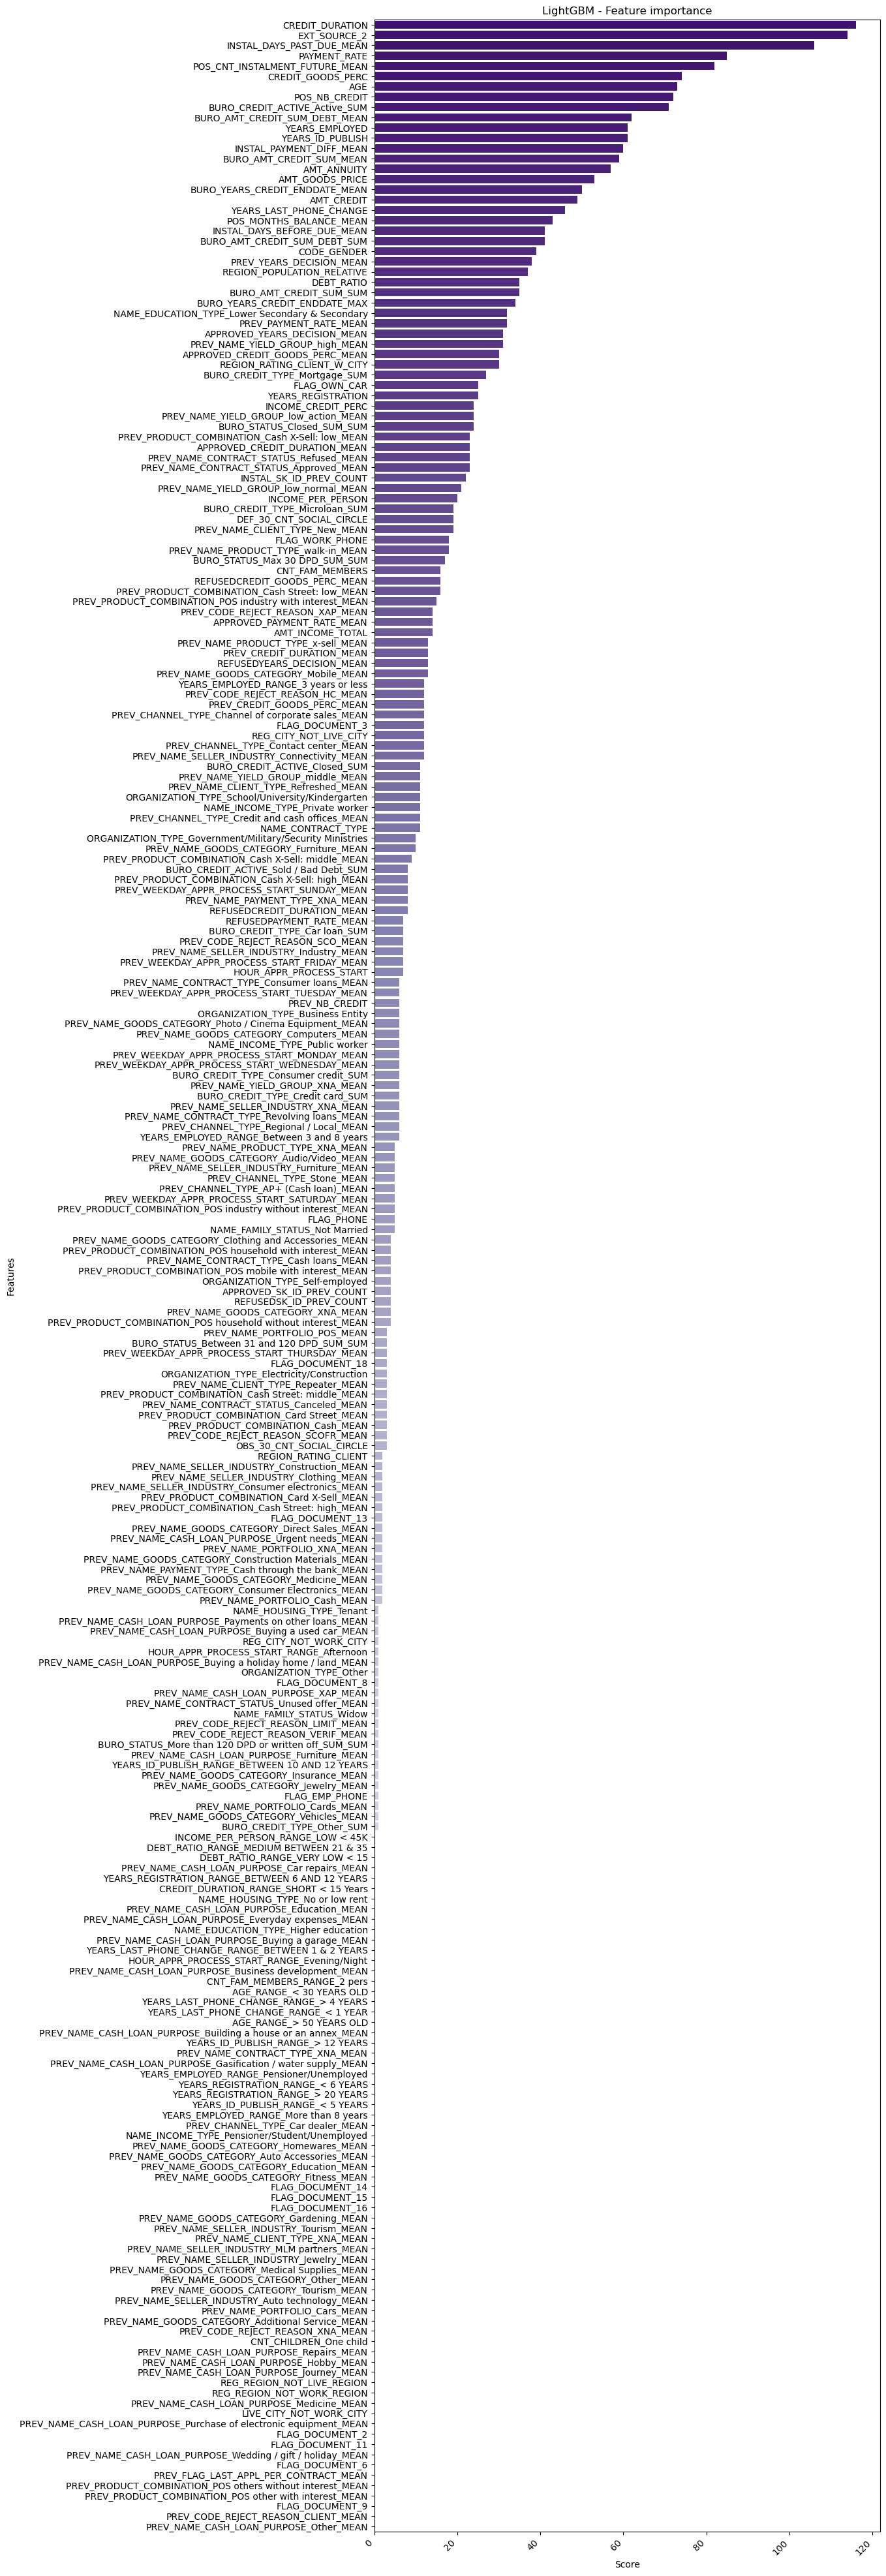

In [143]:
plt.figure(figsize=(10,50))
plt.title('LightGBM - Feature importance')
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df_lgb, x = 'Score', y = 'Features', palette='Purples_r');

Nous allons refaire tourner notre modèle avec les 5, 10 puis 20 variables les plus importantes afin de voir si la réduction de dimension le rend plus ou moins performant:

Avec les 5 variables les plus importantes:

In [144]:
feat_lgb5 = df_lgb[:5]['Features'].tolist()

In [145]:
params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
          "classifier__ n_estimators": [10, 50, 100, 500, 1000, 5000],
          "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
          "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
          "classifier__ boosting_type": ['gbdt', 'dart', 'rf’'],}

lgb5, lgb_params5, lgb_name5, lgb_duration5 = fct_model.best_model(model_name = 'LightGBM - Feature Importance *5',
                                                                   model = LGBMClassifier(random_state = 42,
                                                                                          class_weight='balanced'),
                                                                   cv = KFold(n_splits = 5, 
                                                                              shuffle = True, 
                                                                              random_state = 42),
                                                                   xtrain = X_train[feat_lgb5],
                                                                   ytrain = y_train,
                                                                   preprocessor = StandardScaler(),
                                                                   params = params,
                                                                   scoring = make_scorer(fbeta_score, beta=9),
                                                                   xtest = X_test[feat_lgb5],
                                                                   ytest = y_test,
                                                                   oversampling_strategy = 0.1,
                                                                   undersampling_strategy = 0.5,
                                                                   balanced = False,
                                                                   Randomized = True)

[LightGBM] [Warning] num_leaves is set=31, num_leaves=16 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=50 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=16 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [W

[LightGBM] [Warning] num_leaves is set=31, num_leaves=128 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=9 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=50 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=128 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=9 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [W

[LightGBM] [Warning] num_leaves is set=31, num_leaves=4 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=4 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Wa

[LightGBM] [Warning] num_leaves is set=31, num_leaves=16 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=6 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=500 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=16 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=6 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM]

In [146]:
lgb_params5

{'preprocessor': MinMaxScaler(),
 'classifier__ num_leaves': 16,
 'classifier__ n_estimators': 50,
 'classifier__ max_depth': 2,
 'classifier__ learning_rate': 0.01,
 'classifier__ boosting_type': 'gbdt'}

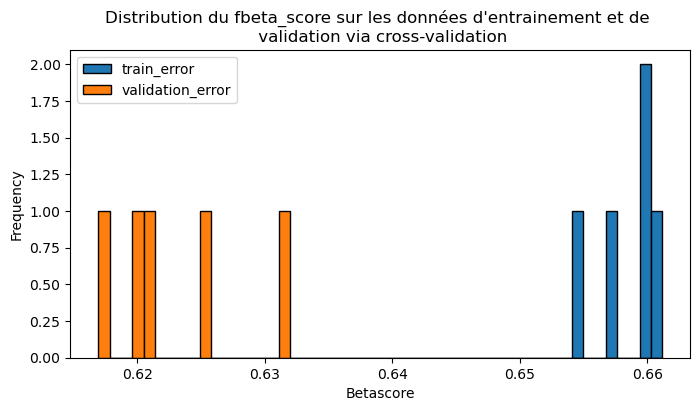

Betascore train set: 0.6584 +/- 0.0026
Betascore validation set: 0.6229 +/- 0.0055


In [147]:
fct_model.compar_train_val_scores(model = lgb5, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train[feat_lgb5],
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [148]:
# Evaluation sur les données de test
(biz_lgb5, beta_lgb5, rec_lgb5, prec_lgb5,
 acc_lgb5, auc_lgb5, y_pred_lgb5) = fct_model.eval_metrics(best_model = lgb5,
                                                           xtest = X_test[feat_lgb5],
                                                           ytest = y_test,
                                                           beta_value = 9)

Score métier: 36203
Beta score: 0.6131603266860877
Recall: 0.6374725054989002
Precision: 0.14994591035228821
Accuracy: 0.6766556641355425
AUC: 0.6587981996521051


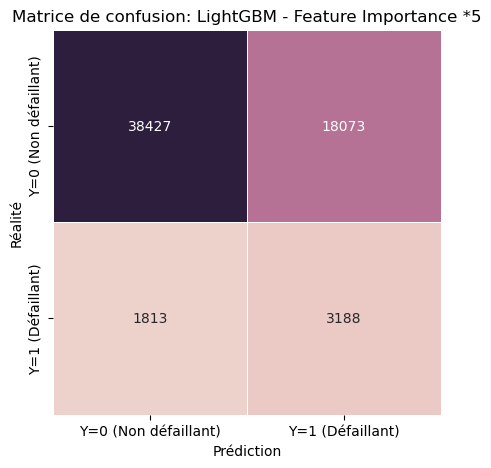

In [149]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb5,
                            model_name = lgb_name5)

In [150]:
dic_df_recap = {'Modèle':[lgb_name5],
                'Best_Params':[lgb_params5],
                'Score_metier':[biz_lgb5],
                'Betascore':[beta_lgb5],
                'Recall':[rec_lgb5], 
                'Precision':[prec_lgb5], 
                'Accuracy':[acc_lgb5], 
                'AUC':[auc_lgb5], 
                "Train_Time": [lgb_duration5],}

df_models_recap_lgb5 = pd.DataFrame(data = dic_df_recap)

In [151]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb5]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                   Best_Params  Score_metier  Betascore  Recall  Precision  \
0           Baseline - Dummy classifier                                                                                                                                                                           {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08   
1                 Régression Logistique                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48   
2  Régression Logistique - Class Weight                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16   
3   Régression Logistique - SMOTE 10/50                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24   
4   Régression Logistique - SMOTE 20/30                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33   
5   Régression Logistique - SMOTE 10/60                                                                                             {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22   
6       Régression Logistique - CW - FS                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14   
7                              LightGBM  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65    0.67       0.17   
8      LightGBM - Feature Importance *5       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 50, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'gbdt'}         36203       0.61    0.64       0.15   

   Accuracy  AUC  Train_Time  
0      0.50 0.49       32.43  
1      0.92 0.51     3753.28  
2      0.69 0.68     4029.51  
3      0.86 0.63     1537.77  
4      0.91 0.54    31617.06  
5      0.83 0.65     1592.45  
6      0.66 0.64       40.80  
7      0.71 0.69      476.24  
8      0.68 0.66       39.96

Avec les 10 variables les plus importantes:

In [152]:
feat_lgb10 = df_lgb[:10]['Features'].tolist()

In [153]:
params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
          "classifier__ n_estimators": [10, 50, 100, 500, 1000, 5000],
          "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
          "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
          "classifier__ boosting_type": ['gbdt', 'dart', 'rf’'],}

lgb10, lgb_params10, lgb_name10, lgb_duration10 = fct_model.best_model(model_name = 'LightGBM - Feature Importance *10',
                                                                       model = LGBMClassifier(random_state = 42,
                                                                                              class_weight='balanced'),
                                                                       cv = KFold(n_splits = 5, 
                                                                                  shuffle = True, 
                                                                                  random_state = 42),
                                                                       xtrain = X_train[feat_lgb10],
                                                                       ytrain = y_train,
                                                                       preprocessor = StandardScaler(),
                                                                       params = params,
                                                                       scoring = make_scorer(fbeta_score, beta=9),
                                                                       xtest = X_test[feat_lgb10],
                                                                       ytest = y_test,
                                                                       oversampling_strategy = 0.1,
                                                                       undersampling_strategy = 0.5,
                                                                       balanced = False,
                                                                       Randomized = True)

[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=5 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=1.0 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=5 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=1.0 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warnin

[LightGBM] [Warning] num_leaves is set=31, num_leaves=512 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=10 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=512 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] 

[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=1.0 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=10 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=1.0 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [War

[LightGBM] [Warning] num_leaves is set=31, num_leaves=256 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=7 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=50 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=256 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=7 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [W

In [154]:
lgb_params10

{'preprocessor': MinMaxScaler(),
 'classifier__ num_leaves': 16,
 'classifier__ n_estimators': 500,
 'classifier__ max_depth': 8,
 'classifier__ learning_rate': 0.1,
 'classifier__ boosting_type': 'gbdt'}

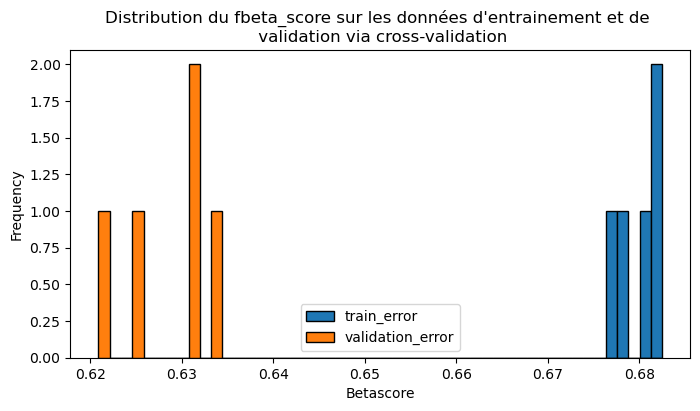

Betascore train set: 0.6801 +/- 0.0023
Betascore validation set: 0.6286 +/- 0.0053


In [155]:
fct_model.compar_train_val_scores(model = lgb10, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train[feat_lgb10],
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [156]:
# Evaluation sur les données de test
(biz_lgb10, beta_lgb10, rec_lgb10, prec_lgb10,
 acc_lgb10, auc_lgb10, y_pred_lgb10) = fct_model.eval_metrics(best_model = lgb10,
                                                              xtest = X_test[feat_lgb10],
                                                              ytest = y_test,
                                                              beta_value = 9)

Score métier: 34980
Beta score: 0.6262320259826265
Recall: 0.6502699460107978
Precision: 0.15678333815446918
Accuracy: 0.6871758182793776
AUC: 0.6703562119434521


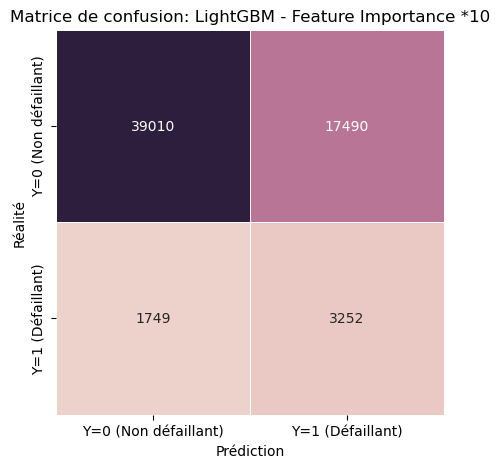

In [157]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb10,
                            model_name = lgb_name10)

In [158]:
dic_df_recap = {'Modèle':[lgb_name10],
                'Best_Params':[lgb_params10],
                'Score_metier':[biz_lgb10],
                'Betascore':[beta_lgb10],
                'Recall':[rec_lgb10], 
                'Precision':[prec_lgb10], 
                'Accuracy':[acc_lgb10], 
                'AUC':[auc_lgb10], 
                "Train_Time": [lgb_duration10],}

df_models_recap_lgb10 = pd.DataFrame(data = dic_df_recap)

In [159]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb10]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                   Best_Params  Score_metier  Betascore  Recall  Precision  \
0           Baseline - Dummy classifier                                                                                                                                                                           {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08   
1                 Régression Logistique                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48   
2  Régression Logistique - Class Weight                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16   
3   Régression Logistique - SMOTE 10/50                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24   
4   Régression Logistique - SMOTE 20/30                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33   
5   Régression Logistique - SMOTE 10/60                                                                                             {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22   
6       Régression Logistique - CW - FS                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14   
7                              LightGBM  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65    0.67       0.17   
8      LightGBM - Feature Importance *5       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 50, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'gbdt'}         36203       0.61    0.64       0.15   
9     LightGBM - Feature Importance *10       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 500, 'classifier__ max_depth': 8, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'gbdt'}         34980       0.63    0.65       0.16   

   Accuracy  AUC  Train_Time  
0      0.50 0.49       32.43  
1      0.92 0.51     3753.28  
2      0.69 0.68     4029.51  
3      0.86 0.63     1537.77  
4      0.91 0.54    31617.06  
5      0.83 0.65     1592.45  
6      0.66 0.64       40.80  
7      0.71 0.69      476.24  
8      0.68 0.66       39.96  
9      0.69 0.67       53.60

Avec les 20 variables les plus importantes:

In [160]:
feat_lgb20 = df_lgb[:20]['Features'].tolist()

In [161]:
params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
          "classifier__ n_estimators": [10, 50, 100, 500, 1000, 5000],
          "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
          "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
          "classifier__ boosting_type": ['gbdt', 'dart', 'rf’'],}

lgb20, lgb_params20, lgb_name20, lgb_duration20 = fct_model.best_model(model_name = 'LightGBM - Feature Importance *20',
                                                                       model = LGBMClassifier(random_state = 42,
                                                                                              class_weight='balanced'),
                                                                       cv = KFold(n_splits = 5, 
                                                                                  shuffle = True, 
                                                                                  random_state = 42),
                                                                       xtrain = X_train[feat_lgb20],
                                                                       ytrain = y_train,
                                                                       preprocessor = StandardScaler(),
                                                                       params = params,
                                                                       scoring = make_scorer(fbeta_score, beta=9),
                                                                       xtest = X_test[feat_lgb20],
                                                                       ytest = y_test,
                                                                       oversampling_strategy = 0.1,
                                                                       undersampling_strategy = 0.5,
                                                                       balanced = False,
                                                                       Randomized = True)

[LightGBM] [Warning] num_leaves is set=31, num_leaves=1024 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=1024 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGB

[LightGBM] [Warning] num_leaves is set=31, num_leaves=1024 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=8 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=10 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=1024 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=8 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=dart will be ignored. Current value: boosting_type=gbdt
[LightGBM] 

[LightGBM] [Warning] num_leaves is set=31, num_leaves=4 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=9 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.0001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=500 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=4 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=9 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.0001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [

[LightGBM] [Warning] num_leaves is set=31, num_leaves=64 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=10 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=64 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [W

In [162]:
lgb_params20

{'preprocessor': StandardScaler(),
 'classifier__ num_leaves': 1024,
 'classifier__ n_estimators': 100,
 'classifier__ max_depth': 4,
 'classifier__ learning_rate': 0.01,
 'classifier__ boosting_type': 'dart'}

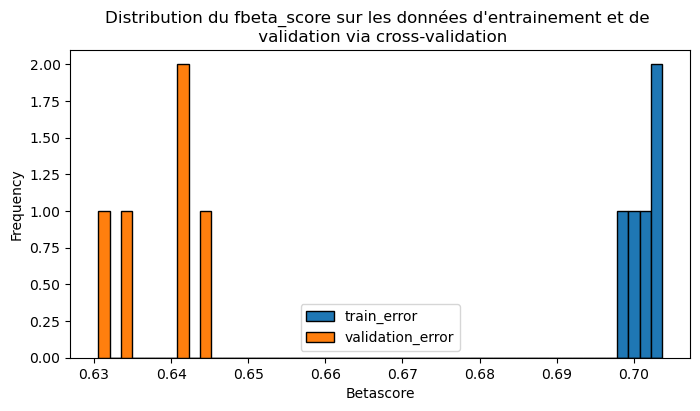

Betascore train set: 0.7013 +/- 0.0024
Betascore validation set: 0.6385 +/- 0.0059


In [163]:
fct_model.compar_train_val_scores(model = lgb20, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train[feat_lgb20],
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [164]:
# Evaluation sur les données de test
(biz_lgb20, beta_lgb20, rec_lgb20, prec_lgb20,
 acc_lgb20, auc_lgb20, y_pred_lgb20) = fct_model.eval_metrics(best_model = lgb20,
                                                              xtest = X_test[feat_lgb20],
                                                              ytest = y_test,
                                                              beta_value = 9)

Score métier: 34051
Beta score: 0.6355453479050939
Recall: 0.6592681463707258
Precision: 0.162349812881623
Accuracy: 0.6956960049430091
AUC: 0.6790942501765134


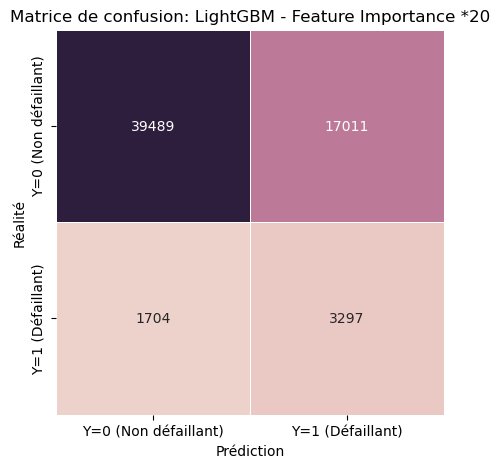

In [165]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb20,
                            model_name = lgb_name20)

In [166]:
dic_df_recap = {'Modèle':[lgb_name20],
                'Best_Params':[lgb_params20],
                'Score_metier':[biz_lgb20],
                'Betascore':[beta_lgb20],
                'Recall':[rec_lgb20], 
                'Precision':[prec_lgb20], 
                'Accuracy':[acc_lgb20], 
                'AUC':[auc_lgb20], 
                "Train_Time": [lgb_duration20],}

df_models_recap_lgb20 = pd.DataFrame(data = dic_df_recap)

In [167]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb20]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                   Best_Params  Score_metier  Betascore  Recall  Precision  \
0            Baseline - Dummy classifier                                                                                                                                                                           {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08   
1                  Régression Logistique                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48   
2   Régression Logistique - Class Weight                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16   
3    Régression Logistique - SMOTE 10/50                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24   
4    Régression Logistique - SMOTE 20/30                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33   
5    Régression Logistique - SMOTE 10/60                                                                                             {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22   
6        Régression Logistique - CW - FS                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14   
7                               LightGBM  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65    0.67       0.17   
8       LightGBM - Feature Importance *5       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 50, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'gbdt'}         36203       0.61    0.64       0.15   
9      LightGBM - Feature Importance *10       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 500, 'classifier__ max_depth': 8, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'gbdt'}         34980       0.63    0.65       0.16   
10     LightGBM - Feature Importance *20  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 100, 'classifier__ max_depth': 4, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'dart'}         34051       0.64    0.66       0.16   

    Accuracy  AUC  Train_Time  
0       0.50 0.49       32.43  
1       0.92 0.51     3753.28  
2       0.69 0.68     4029.51  
3       0.86 0.63     1537.77  
4       0.91 0.54    31617.06  
5       0.83 0.65     1592.45  
6       0.66 0.64       40.80  
7       0.71 0.69      476.24  
8       0.68 0.66       39.96  
9       0.69 0.67       53.60  
10      0.70 0.68       76.90

Avec les 30 variables les plus importantes:

In [168]:
feat_lgb30 = df_lgb[:30]['Features'].tolist()

In [169]:
params = {"preprocessor" : [StandardScaler(), MinMaxScaler()],
          "classifier__ n_estimators": [10, 50, 100, 500, 1000, 5000],
          "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
          "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
          "classifier__ boosting_type": ['gbdt', 'dart', 'rf’'],}

lgb30, lgb_params30, lgb_name30, lgb_duration30 = fct_model.best_model(model_name = 'LightGBM - Feature Importance *30',
                                                                       model = LGBMClassifier(random_state = 42,
                                                                                              class_weight='balanced'),
                                                                       cv = KFold(n_splits = 5, 
                                                                                  shuffle = True, 
                                                                                  random_state = 42),
                                                                       xtrain = X_train[feat_lgb30],
                                                                       ytrain = y_train,
                                                                       preprocessor = StandardScaler(),
                                                                       params = params,
                                                                       scoring = make_scorer(fbeta_score, beta=9),
                                                                       xtest = X_test[feat_lgb30],
                                                                       ytest = y_test,
                                                                       oversampling_strategy = 0.1,
                                                                       undersampling_strategy = 0.5,
                                                                       balanced = False,
                                                                       Randomized = True)

[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=500 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Wa

[LightGBM] [Warning] num_leaves is set=31, num_leaves=32 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=7 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=50 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=32 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=7 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warni

[LightGBM] [Warning] num_leaves is set=31, num_leaves=128 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=5000 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=128 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM

[LightGBM] [Warning] num_leaves is set=31, num_leaves=16 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=50 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=16 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [W

In [170]:
lgb_params30

{'preprocessor': StandardScaler(),
 'classifier__ num_leaves': 2,
 'classifier__ n_estimators': 1000,
 'classifier__ max_depth': 1,
 'classifier__ learning_rate': 0.1,
 'classifier__ boosting_type': 'rf’'}

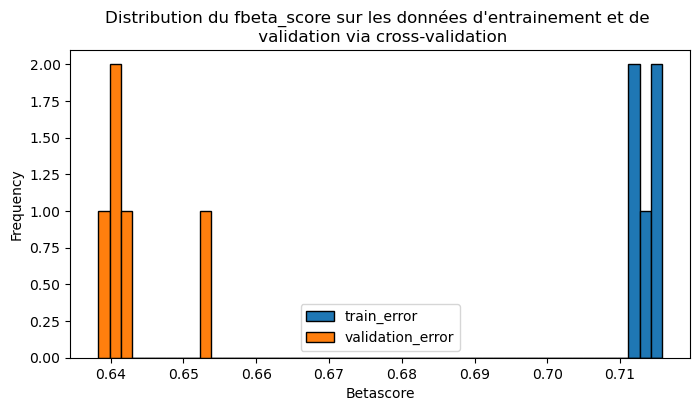

Betascore train set: 0.7136 +/- 0.0017
Betascore validation set: 0.6429 +/- 0.0056


In [171]:
fct_model.compar_train_val_scores(model = lgb30, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train[feat_lgb30],
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [172]:
# Evaluation sur les données de test
(biz_lgb30, beta_lgb30, rec_lgb30, prec_lgb30,
 acc_lgb30, auc_lgb30, y_pred_lgb30) = fct_model.eval_metrics(best_model = lgb30,
                                                              xtest = X_test[feat_lgb30],
                                                              ytest = y_test,
                                                              beta_value = 9)

Score métier: 33173
Beta score: 0.6430373550233468
Recall: 0.6662667466506699
Precision: 0.16815543779964673
Accuracy: 0.704850327636949
AUC: 0.6872661166881668


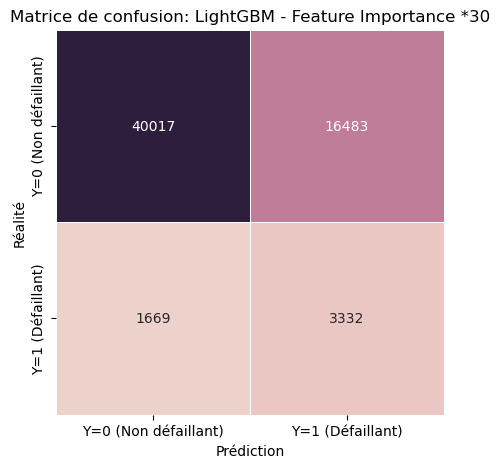

In [173]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb30,
                            model_name = lgb_name30)

In [174]:
dic_df_recap = {'Modèle':[lgb_name30],
                'Best_Params':[lgb_params30],
                'Score_metier':[biz_lgb30],
                'Betascore':[beta_lgb30],
                'Recall':[rec_lgb30], 
                'Precision':[prec_lgb30], 
                'Accuracy':[acc_lgb30], 
                'AUC':[auc_lgb30], 
                "Train_Time": [lgb_duration30],}

df_models_recap_lgb30 = pd.DataFrame(data = dic_df_recap)

In [175]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb30]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                   Best_Params  Score_metier  Betascore  Recall  Precision  \
0            Baseline - Dummy classifier                                                                                                                                                                           {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08   
1                  Régression Logistique                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48   
2   Régression Logistique - Class Weight                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16   
3    Régression Logistique - SMOTE 10/50                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24   
4    Régression Logistique - SMOTE 20/30                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33   
5    Régression Logistique - SMOTE 10/60                                                                                             {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22   
6        Régression Logistique - CW - FS                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14   
7                               LightGBM  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65    0.67       0.17   
8       LightGBM - Feature Importance *5       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 50, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'gbdt'}         36203       0.61    0.64       0.15   
9      LightGBM - Feature Importance *10       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 500, 'classifier__ max_depth': 8, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'gbdt'}         34980       0.63    0.65       0.16   
10     LightGBM - Feature Importance *20  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 100, 'classifier__ max_depth': 4, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'dart'}         34051       0.64    0.66       0.16   
11     LightGBM - Feature Importance *30      {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 2, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 1, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'rf’'}         33173       0.64    0.67       0.17   

    Accuracy  AUC  Train_Time  
0       0.50 0.49       32.43  
1       0.92 0.51     3753.28  
2       0.69 0.68     4029.51  
3       0.86 0.63     1537.77  
4       0.91 0.54    31617.06  
5       0.83 0.65  

Une sélection plus parcimonieuse des variables en entrée n'a pas permis d'obtenir de meilleure score mais un score presque équivalent. De plus le temps d'entrainement est bien plus faible lorsque l'on retire des variables. Pour des raisons de performance, nous allons effectuer une tentative de fine tuning via GridSearchCV.

#### Tentative de fine tuning via GridSearchCV

Nous allons cette fois ci affiner notre recherche d'hyperparamètres en affinant notre grille et en passant par un GridSearchCV au lieu d'un RandomizedSearchCV:

In [176]:
params = {"classifier__ n_estimators": [100, 200, 300, 500, 600, 800],
          "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          "classifier__ num_leaves": [2, 4, 6, 8, 10, 15, 20, 32, 60, 64, 70, 128, 256, 512, 1024],
          "classifier__ learning_rate": [0.001, 0.002, 0.005, 0.007, 0.01, 0.1, 0.2, 0.5, 1.0],
          "classifier__ boosting_type": ['gbdt', 'rf’'],}

(lgb30_gscv, lgb30_params_gscv,
 lgb30_name_gscv, lgb30_duration_gscv) = fct_model.best_model(model_name = 'LightGBM 30 - GridSearchCV',
                                                              model = LGBMClassifier(random_state = 42,
                                                                                     class_weight='balanced'),
                                                              cv = KFold(n_splits = 5, 
                                                                         shuffle = True, 
                                                                         random_state = 42),
                                                              xtrain = X_train[feat_lgb30],
                                                              ytrain = y_train,
                                                              preprocessor = StandardScaler(),
                                                              params = params,
                                                              scoring = make_scorer(fbeta_score, beta=9),
                                                              xtest = X_test[feat_lgb30],
                                                              ytest = y_test,
                                                              oversampling_strategy = 0.1,
                                                              undersampling_strategy = 0.5,
                                                              balanced = False,
                                                              Randomized = False)

[LightGBM] [Warning] num_leaves is set=31, num_leaves=15 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=200 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=15 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=2 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [

[LightGBM] [Warning] num_leaves is set=31, num_leaves=512 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=5 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.002 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=512 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=5 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.002 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM]

[LightGBM] [Warning] num_leaves is set=31, num_leaves=2 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=6 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=200 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=2 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=6 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warn

[LightGBM] [Warning] num_leaves is set=31, num_leaves=6 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.002 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=800 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=6 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=10 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.002 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM]

In [177]:
lgb30_params_gscv

{'classifier__ num_leaves': 15,
 'classifier__ n_estimators': 200,
 'classifier__ max_depth': 2,
 'classifier__ learning_rate': 0.001,
 'classifier__ boosting_type': 'rf’'}

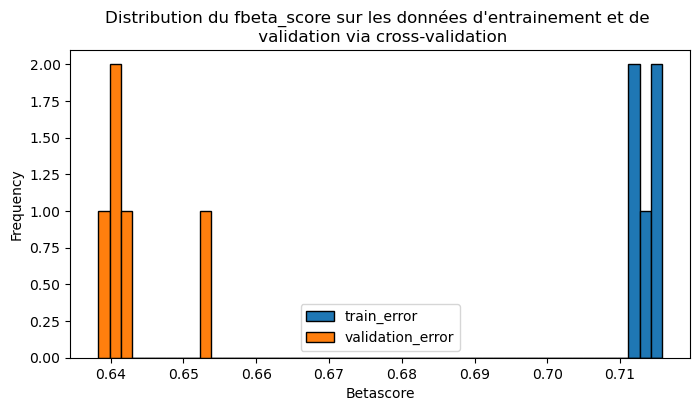

Betascore train set: 0.7136 +/- 0.0017
Betascore validation set: 0.6429 +/- 0.0056


In [178]:
fct_model.compar_train_val_scores(model = lgb30_gscv, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train[feat_lgb30],
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [179]:
# Evaluation sur les données de test
(biz_lgb30_gscv, beta_lgb30_gscv, rec_lgb30_gscv, prec_lgb30_gscv,
 acc_lgb30_gscv, auc_lgb30_gscv, y_pred_lgb30_gscv) = fct_model.eval_metrics(best_model = lgb30_gscv,
                                                                             xtest = X_test[feat_lgb30],
                                                                             ytest = y_test,
                                                                             beta_value = 9)

Score métier: 33173
Beta score: 0.6430373550233468
Recall: 0.6662667466506699
Precision: 0.16815543779964673
Accuracy: 0.704850327636949
AUC: 0.6872661166881668


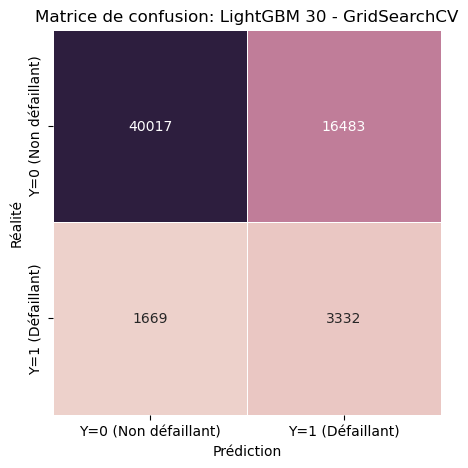

In [180]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb30_gscv,
                            model_name = lgb30_name_gscv)

In [181]:
dic_df_recap = {'Modèle':[lgb30_name_gscv],
                'Best_Params':[lgb30_params_gscv],
                'Score_metier':[biz_lgb30_gscv],
                'Betascore':[beta_lgb30_gscv],
                'Recall':[rec_lgb30_gscv], 
                'Precision':[prec_lgb30_gscv], 
                'Accuracy':[acc_lgb30_gscv], 
                'AUC':[auc_lgb30_gscv], 
                "Train_Time": [lgb30_duration_gscv],}

df_models_recap_lgb30_gscv = pd.DataFrame(data = dic_df_recap)

In [182]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb30_gscv]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                   Best_Params  Score_metier  Betascore  Recall  Precision  \
0            Baseline - Dummy classifier                                                                                                                                                                           {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08   
1                  Régression Logistique                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48   
2   Régression Logistique - Class Weight                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16   
3    Régression Logistique - SMOTE 10/50                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24   
4    Régression Logistique - SMOTE 20/30                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33   
5    Régression Logistique - SMOTE 10/60                                                                                             {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22   
6        Régression Logistique - CW - FS                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14   
7                               LightGBM  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65    0.67       0.17   
8       LightGBM - Feature Importance *5       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 50, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'gbdt'}         36203       0.61    0.64       0.15   
9      LightGBM - Feature Importance *10       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 500, 'classifier__ max_depth': 8, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'gbdt'}         34980       0.63    0.65       0.16   
10     LightGBM - Feature Importance *20  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 100, 'classifier__ max_depth': 4, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'dart'}         34051       0.64    0.66       0.16   
11     LightGBM - Feature Importance *30      {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 2, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 1, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'rf’'}         33173       0.64    0.67       0.17   
12            LightGBM 30 - GridSearchCV                                      {'classifier__ num_leaves': 15, 'classifier__ n_estimators': 200, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.001, 'c

#### Tentative d'amélioration de la précision avec scoring sur beta moins important

In [183]:
params = {"classifier__ n_estimators": [100, 200, 300, 500, 600, 800],
          "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          "classifier__ num_leaves": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25],
          "classifier__ learning_rate": [0.001, 0.002, 0.005, 0.007, 0.01, 0.1, 1.0],
          "classifier__ boosting_type": ['gbdt', 'rf’'],}

(lgb30_gscv_b2, lgb30_params_gscv_b2,
 lgb30_name_gscv_b2, lgb30_duration_gscv_b2) = fct_model.best_model(model_name = 'LightGBM 30 - Beta = 2',
                                                                    model = LGBMClassifier(random_state = 42,
                                                                                           class_weight='balanced'),
                                                                    cv = KFold(n_splits = 5, 
                                                                               shuffle = True, 
                                                                               random_state = 42),
                                                                    xtrain = X_train[feat_lgb30],
                                                                    ytrain = y_train,
                                                                    preprocessor = StandardScaler(),
                                                                    params = params,
                                                                    scoring = make_scorer(fbeta_score, beta=2),
                                                                    xtest = X_test[feat_lgb30],
                                                                    ytest = y_test,
                                                                    oversampling_strategy = 0.1,
                                                                    undersampling_strategy = 0.5,
                                                                    balanced = False,
                                                                    Randomized = False)

[LightGBM] [Warning] num_leaves is set=31, num_leaves=2 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=9 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=1.0 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=200 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=2 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=9 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=1.0 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warnin

[LightGBM] [Warning] num_leaves is set=31, num_leaves=13 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.007 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=800 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=13 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=4 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.007 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=rf’ will be ignored. Current value: boosting_type=gbdt
[LightGBM] [

[LightGBM] [Warning] num_leaves is set=31, num_leaves=13 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=7 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.002 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=13 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=7 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.002 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM]

[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=8 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.007 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_iterations is set=100, n_estimators=600 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_leaves is set=31, num_leaves=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] max_depth is set=-1, max_depth=8 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.007 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting_type=gbdt
[LightGBM] [

In [184]:
lgb30_params_gscv_b2

{'classifier__ num_leaves': 2,
 'classifier__ n_estimators': 200,
 'classifier__ max_depth': 9,
 'classifier__ learning_rate': 1.0,
 'classifier__ boosting_type': 'rf’'}

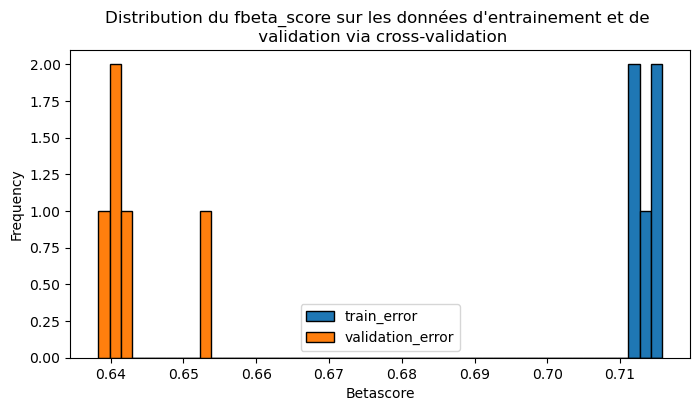

Betascore train set: 0.7136 +/- 0.0017
Betascore validation set: 0.6429 +/- 0.0056


In [185]:
fct_model.compar_train_val_scores(model = lgb30_gscv_b2, 
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                  xtrain = X_train[feat_lgb30],
                                  ytrain = y_train,
                                  scoring = make_scorer(fbeta_score, beta=9))

In [186]:
# Evaluation sur les données de test
(biz_lgb30_gscv_b2, beta_lgb30_gscv_b2, rec_lgb30_gscv_b2, prec_lgb30_gscv_b2,
 acc_lgb30_gscv_b2, auc_lgb30_gscv_b2, y_pred_lgb30_gscv_b2) = fct_model.eval_metrics(best_model = lgb30_gscv_b2,
                                                                                      xtest = X_test[feat_lgb30],
                                                                                      ytest = y_test,
                                                                                      beta_value = 9)

Score métier: 33173
Beta score: 0.6430373550233468
Recall: 0.6662667466506699
Precision: 0.16815543779964673
Accuracy: 0.704850327636949
AUC: 0.6872661166881668


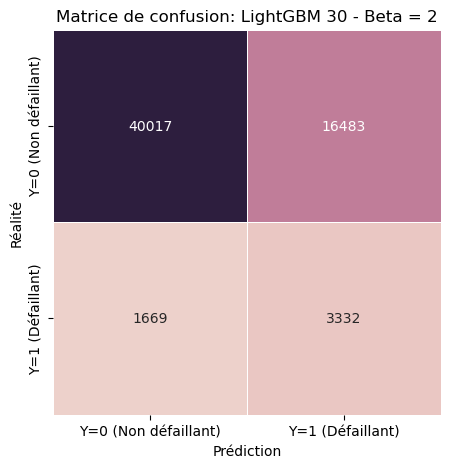

In [188]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb30_gscv_b2,
                            model_name = lgb30_name_gscv_b2)

In [189]:
dic_df_recap = {'Modèle':[lgb30_name_gscv_b2],
                'Best_Params':[lgb30_params_gscv_b2],
                'Score_metier':[biz_lgb30_gscv_b2],
                'Betascore':[beta_lgb30_gscv_b2],
                'Recall':[rec_lgb30_gscv_b2], 
                'Precision':[prec_lgb30_gscv_b2], 
                'Accuracy':[acc_lgb30_gscv_b2], 
                'AUC':[auc_lgb30_gscv_b2], 
                "Train_Time": [lgb30_duration_gscv_b2],}

df_models_recap_lgb30_gscv_b2 = pd.DataFrame(data = dic_df_recap)

In [190]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb30_gscv_b2]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                   Best_Params  Score_metier  Betascore  Recall  Precision  \
0            Baseline - Dummy classifier                                                                                                                                                                           {'classifier__strategy': 'uniform'}         53949       0.46    0.49       0.08   
1                  Régression Logistique                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01    0.01       0.48   
2   Régression Logistique - Class Weight                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64    0.67       0.16   
3    Régression Logistique - SMOTE 10/50                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36    0.36       0.24   
4    Régression Logistique - SMOTE 20/30                                                                                           {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09    0.09       0.33   
5    Régression Logistique - SMOTE 10/60                                                                                             {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43    0.43       0.22   
6        Régression Logistique - CW - FS                                                                                          {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59    0.61       0.14   
7                               LightGBM  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65    0.67       0.17   
8       LightGBM - Feature Importance *5       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 50, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'gbdt'}         36203       0.61    0.64       0.15   
9      LightGBM - Feature Importance *10       {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 500, 'classifier__ max_depth': 8, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'gbdt'}         34980       0.63    0.65       0.16   
10     LightGBM - Feature Importance *20  {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 100, 'classifier__ max_depth': 4, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'dart'}         34051       0.64    0.66       0.16   
11     LightGBM - Feature Importance *30      {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 2, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 1, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'rf’'}         33173       0.64    0.67       0.17   
12            LightGBM 30 - GridSearchCV                                      {'classifier__ num_leaves': 15, 'classifier__ n_estimators': 200, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.001, 'c

La sélection du meilleure modèle par GridSearchCV en fonction du fbeta_score avec beta = 2 n'a pas permis d'améliorer le modèle.

#### Optimisation des hyperparamètres via FLAML

**FLAML** est une bibliothèque Python qui trouve des modèles de classification ou encore régression précis de manière automatique, efficace et avec de faibles ressources informatiques. Elle peut également être utilisée pour **régler des hyperparamètres** pour des modèles de base.

Ici, les metrics sont à minimiser, nous allons utiliser le built_in metric 'f1'.

https://github.com/microsoft/FLAML

https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML/#estimator-and-search-space

In [192]:
automl = AutoML()
automl.fit(X_train[feat_lgb30], y_train, task = "classification", estimator_list=["lgbm"], metric='f1')

[flaml.automl.logger: 05-04 15:15:44] {1682} INFO - task = classification
[flaml.automl.logger: 05-04 15:15:44] {1689} INFO - Data split method: stratified
[flaml.automl.logger: 05-04 15:15:44] {1692} INFO - Evaluation method: cv
[flaml.automl.logger: 05-04 15:15:44] {1790} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 05-04 15:15:44] {1812} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
[flaml.automl.logger: 05-04 15:15:44] {1900} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 05-04 15:19:09] {2619} INFO - retrain lgbm for 204.7s
[flaml.automl.logger: 05-04 15:19:09] {2622} INFO - retrained model: LGBMClassifier(colsample_bytree=0.5393339924944204,
               learning_rate=0.009033979476164342, max_bin=1023,
               mi

In [193]:
print('Meilleurs hyperparamètres:', automl.best_config)

Meilleurs hyperparamètres: {'n_estimators': 31204, 'num_leaves': 4, 'min_child_samples': 3, 'learning_rate': 0.009033979476164342, 'log_max_bin': 10, 'colsample_bytree': 0.5393339924944204, 'reg_alpha': 15.800090067239827, 'reg_lambda': 34.82471227276953}


Nous allons faire tourner notre modèle avec les scores trouvés par la bibliothèque FLAML:

In [195]:
start_lgb30_FLAM = time.time()
model = LGBMClassifier(n_estimators = 31204, num_leaves = 4,
                       min_child_samples = 3, learning_rate = 0.009033979476164342,
                       log_max_bin = 10, colsample_bytree = 0.5393339924944204, 
                       reg_alpha = 15.800090067239827, reg_lambda = 34.82471227276953,
                       random_state = 42, class_weight='balanced')

lgb30_FLAM = fct_model.pipeline_model(model = model, 
                                      preprocessor = StandardScaler())

lgb30_FLAM.fit(X_train[feat_lgb30], y_train)
duration_lgb30_FLAM = time.time() - start_lgb30_FLAM

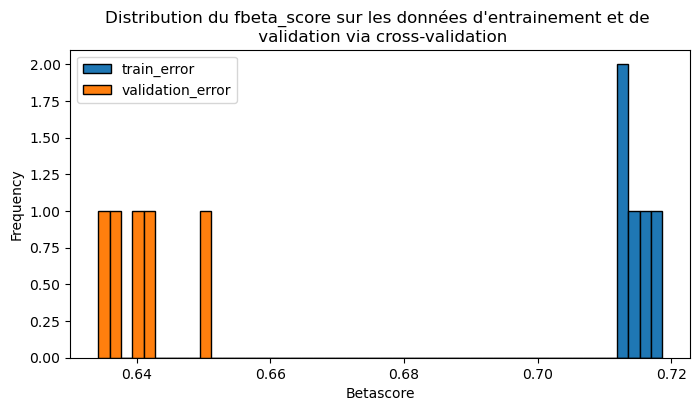

Betascore train set: 0.7154 +/- 0.0023
Betascore validation set: 0.6408 +/- 0.0059


In [196]:
fct_model.compar_train_val_scores(model = lgb30_FLAM,
                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42), 
                                  xtrain = X_train[feat_lgb30],
                                  ytrain = y_train, 
                                  scoring = make_scorer(fbeta_score, beta=9))

In [198]:
# Evaluation sur les données de test
(biz_lgb30_FLAM, beta_lgb30_FLAM, rec_lgb30_FLAM, prec_lgb30_FLAM,
 acc_lgb30_FLAM, auc_lgb30_FLAM, y_pred_lgb30_FLAM) = fct_model.eval_metrics(best_model = lgb30_FLAM,
                                                                             xtest = X_test[feat_lgb30],
                                                                             ytest = y_test,
                                                                             beta_value = 9)

Score métier: 32750
Beta score: 0.6383790372586604
Recall: 0.6602679464107178
Precision: 0.17322421571713356
Accuracy: 0.7161184370985838
AUC: 0.6906649466566864


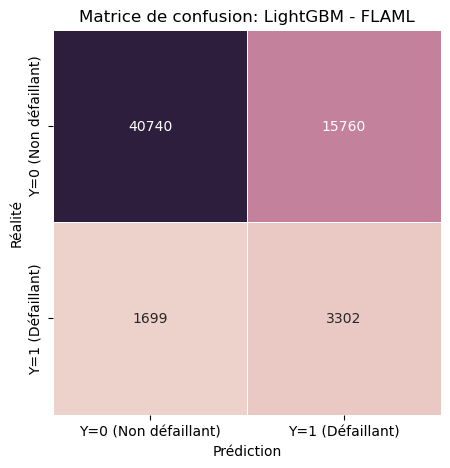

In [199]:
fct_model.matrice_confusion(ytest = y_test,
                            ypred = y_pred_lgb30_FLAM,
                            model_name = 'LightGBM - FLAML')

In [201]:
dic_df_recap = {'Modèle': 'LightGBM 30 - FLAML',
                'Best_Params':[automl.best_config],
                'Score_metier':[biz_lgb30_FLAM],
                'Betascore':[beta_lgb30_FLAM],
                'Recall':[rec_lgb30_FLAM], 
                'Precision':[prec_lgb30_FLAM], 
                'Accuracy':[acc_lgb30_FLAM], 
                'AUC':[auc_lgb30_FLAM], 
                "Train_Time": [duration_lgb30_FLAM],}

df_models_recap_lgb30_FLAM = pd.DataFrame(data = dic_df_recap)

In [202]:
df_models_recap = pd.concat([df_models_recap, df_models_recap_lgb30_FLAM]).reset_index(drop = True)
df_models_recap

Modèle                                                                                                                                                                                                                           Best_Params  Score_metier  Betascore  \
0            Baseline - Dummy classifier                                                                                                                                                                                                   {'classifier__strategy': 'uniform'}         53949       0.46   
1                  Régression Logistique                                                                                                                  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}         49378       0.01   
2   Régression Logistique - Class Weight                                                                                                                   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}         33977       0.64   
3    Régression Logistique - SMOTE 10/50                                                                                                                   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         37488       0.36   
4    Régression Logistique - SMOTE 20/30                                                                                                                   {'preprocessor': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         46480       0.09   
5    Régression Logistique - SMOTE 10/60                                                                                                                     {'preprocessor': MinMaxScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}         36042       0.43   
6        Régression Logistique - CW - FS                                                                                                                  {'preprocessor': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1.0}         38147       0.59   
7                               LightGBM                          {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'dart'}         32546       0.65   
8       LightGBM - Feature Importance *5                               {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 50, 'classifier__ max_depth': 2, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'gbdt'}         36203       0.61   
9      LightGBM - Feature Importance *10                               {'preprocessor': MinMaxScaler(), 'classifier__ num_leaves': 16, 'classifier__ n_estimators': 500, 'classifier__ max_depth': 8, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'gbdt'}         34980       0.63   
10     LightGBM - Feature Importance *20                          {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 1024, 'classifier__ n_estimators': 100, 'classifier__ max_depth': 4, 'classifier__ learning_rate': 0.01, 'classifier__ boosting_type': 'dart'}         34051       0.64   
11     LightGBM - Feature Importance *30                              {'preprocessor': StandardScaler(), 'classifier__ num_leaves': 2, 'classifier__ n_estimators': 1000, 'classifier__ max_depth': 1, 'classifier__ learning_rate': 0.1, 'classifier__ boosting_type': 'rf’'}         33173       0.64   
12            LightGBM 30 - GridSearchCV                                                              {'classifier__ num_leaves': 15, 'classifier__

In [203]:
# Dataframe
feats_lgb30_FLAM = X_train[feat_lgb30].columns
feat_imp_lgb30_FLAM = lgb30_FLAM.named_steps['classifier'].feature_importances_

dic_lgb30_FLAM = {'Features': feats_lgb30_FLAM,
           'Score': feat_imp_lgb30_FLAM}
df_lgb30_FLAM = pd.DataFrame(data = dic_lgb30_FLAM)
df_lgb30_FLAM = df_lgb30_FLAM.sort_values(by='Score', ascending = False)

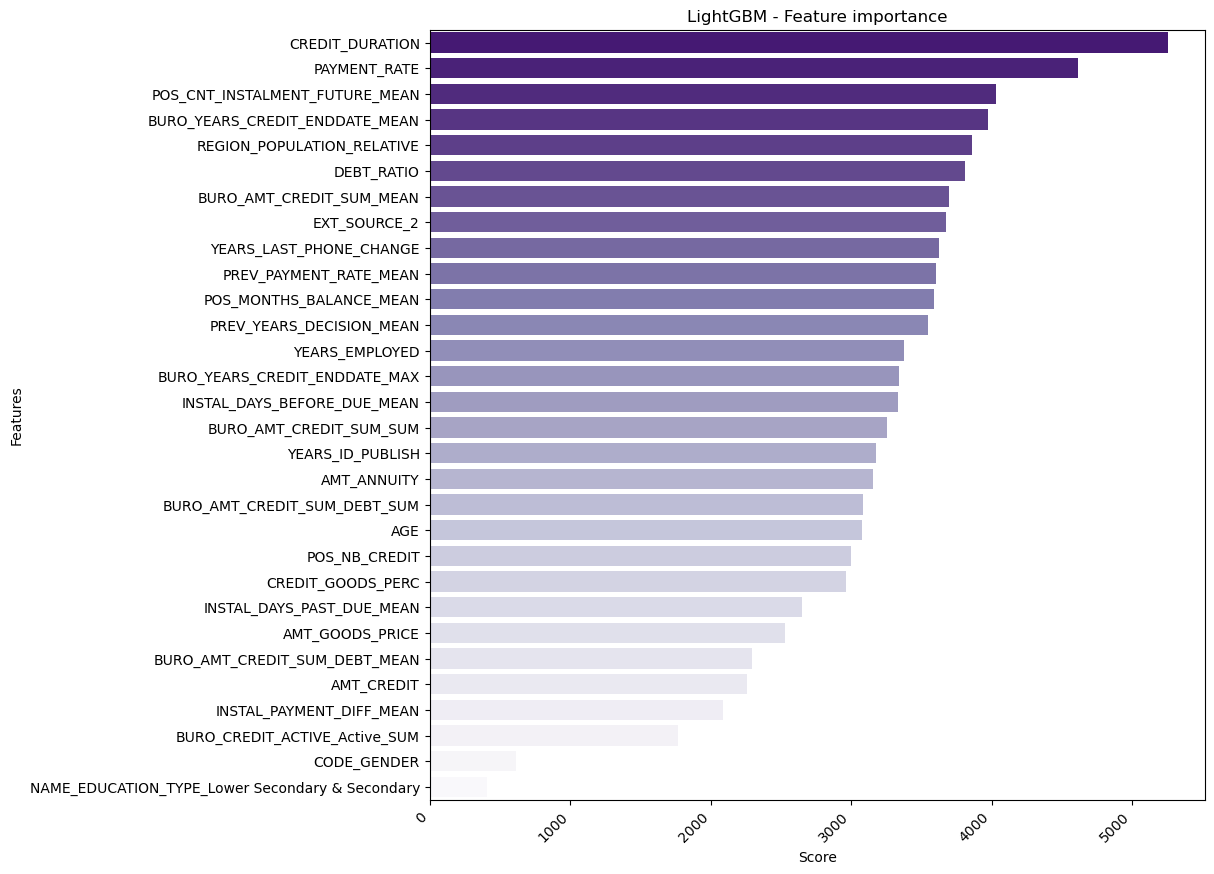

In [206]:
# Features importance
plt.figure(figsize=(10,10))
plt.title('LightGBM - Feature importance')
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df_lgb30_FLAM, x = 'Score', y = 'Features', palette='Purples_r');

## Sélection du meilleur modèle <a class="anchor" id="best"></a>

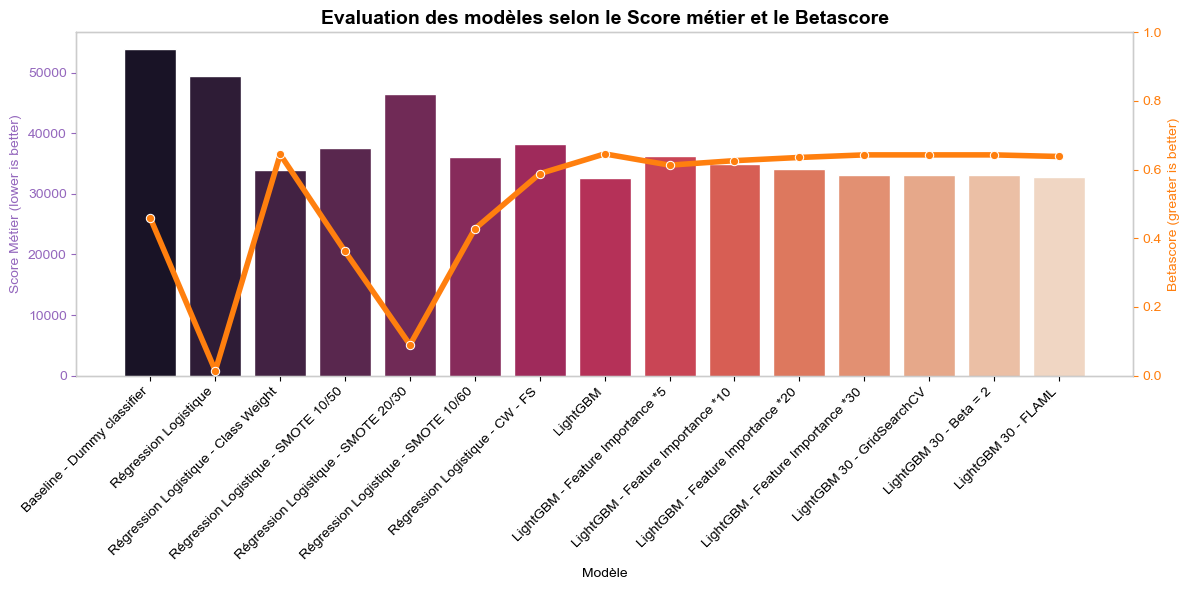

In [207]:
# Création d'un barplot montrant la performance sur le fbeta_score et le score métier
fig, ax1 = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")

sns.barplot(data = df_models_recap, x ='Modèle', y ='Score_metier',  palette ="rocket", ax = ax1)

ax1.set_title("Evaluation des modèles selon le Score métier et le Betascore", 
              fontweight = "bold", fontsize=14)
ax1.set_xticklabels(df_models_recap['Modèle'], rotation=45, ha='right')
ax1.yaxis.label.set_color('tab:purple')
ax1.tick_params(axis='y', colors='tab:purple')
ax1.set_ylabel(r'Score Métier (lower is better)')

ax2 = ax1.twinx()
sns.lineplot(data = df_models_recap["Betascore"], marker='o', sort = False, 
             color='tab:orange', linewidth=4, ax=ax2)
ax2.set(ylim=(0, 1))
ax2.yaxis.label.set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.set_ylabel(r'Betascore (greater is better)')
ax2.grid(None)
plt.tight_layout()
plt.show()

Le modèle LightGBM avec optimisation des hyperparamètres via AutoML est le plus performant tant au niveau du score métier que du betascore. Nous allons reproduire ce graphique en prenant le temps d'entrainement et le score métier:

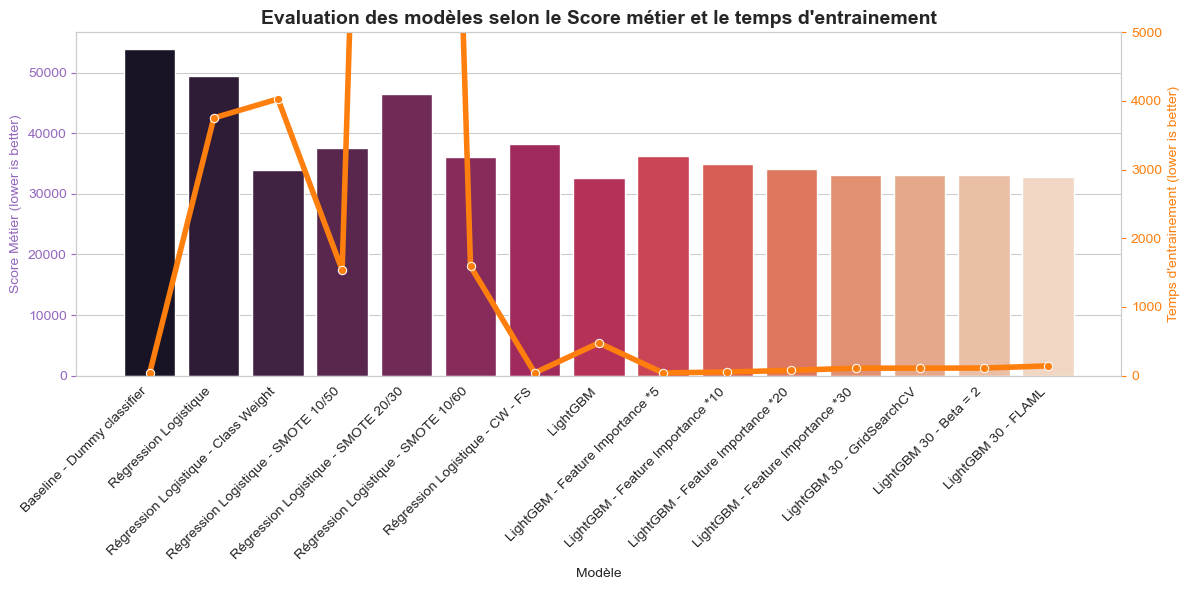

In [212]:
# Création d'un barplot montrant la performance sur le score métier et le temps d'entrainement
fig, ax1 = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")

sns.barplot(data = df_models_recap, x ='Modèle', y ='Score_metier',  palette ="rocket", ax = ax1)

ax1.set_title("Evaluation des modèles selon le Score métier et le temps d'entrainement", 
              fontweight = "bold", fontsize=14)
ax1.set_xticklabels(df_models_recap['Modèle'], rotation=45, ha='right')
ax1.yaxis.label.set_color('tab:purple')
ax1.tick_params(axis='y', colors='tab:purple')
ax1.set_ylabel(r'Score Métier (lower is better)')

ax2 = ax1.twinx()
sns.lineplot(data = df_models_recap["Train_Time"], marker='o', sort = False, 
             color='tab:orange', linewidth=4, ax=ax2)
ax2.set(ylim=(0, 5000))
ax2.yaxis.label.set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.set_ylabel(r"Temps d'entrainement (lower is better)")
ax2.grid(None)
plt.tight_layout()
plt.show()

Le LightGBM avec les 30 features les plus importantes optimisé via FLAML est le modèle qui associe: 
- un score métier faible
- un temps d'entrainement relativement court
- un fbetascore important
- un nombre de features relativement faible
- des features facilement explicables pour quelqu'un de non expert en datascience

Nous souhaitons ici non pas prédire si le client est ou n'est pas défaillant mais avoir une **probabilité d'appartenance à l'une ou l'autre classe**. C'est ce qu'on appelle une prédiction de probabilité où le modèle va renvoyer la probabilité pour chaque classe de résultats sous la forme d'une valeur comprise entre 0 et 1.

La courbe ROC (Receiver Operating Characteristic) trace le taux de vrais positifs en fonction du taux de faux positifs et représente les performances du modèle.

L'aire sous la courbe ROC  est une mesure de performance pour les problèmes de classification binaire. L'aire sous la courbe représente la **capacité d'un modèle à discriminer les classes positives et négatives**.

Une aire de 1 représenterait un modèle qui prédit parfaitement et une aire de 0.5, un modèle qui serait aussi bon qu'un modèle aléatoire.

Comment choisir un seuil de décision à partir de cette courbe ? On se fixe soit la spécificité, soit la sensibilité que l'on désire, et on cherche le seuil correspondant. La sensibilité et la spécificité permettent d’analyser la capacité du modèle à prédire la vérité:

- **sensibilité** = VP / (VP + FN) Taux de vrais positifs
- **spécificité** = VN / (VN + FP) Taux de faux positifs

Dans notre cas, nous souhaitons que l'algorithme soit capable de détecter efficacement les clients défaillants. Nous souhaitons donc maximiser le nombre de vrais positifs (client défaillant prédit défaillant) mais sans trop augmenter le nombre de faux positifs.

Nous allons calculer les taux de vrais positifs et faux positifs en fonction de différents seuils:

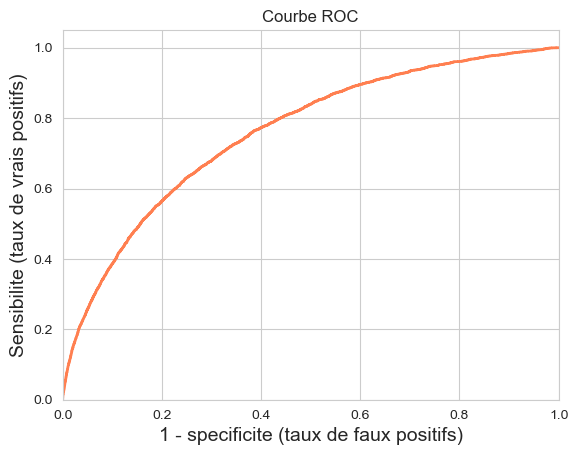

In [214]:
y_pred_proba = lgb30_FLAM.predict_proba(X_test[feat_lgb30])[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (taux de faux positifs)', fontsize=14)
plt.ylabel('Sensibilite (taux de vrais positifs)', fontsize=14)
plt.title('Courbe ROC');

In [215]:
for i in (0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9):
    idx = np.min(np.where(tpr > i)) 
    print(f'A un seuil de {round(thr[idx],2)}: ')
    print("Taux de vrais positifs : {:.2f}".format(tpr[idx]))
    print("Taux de faux positifs : {:.2f}".format(fpr[idx]))
    print()

A un seuil de 0.73: 
Taux de vrais positifs : 0.30
Taux de faux positifs : 0.06

A un seuil de 0.67: 
Taux de vrais positifs : 0.40
Taux de faux positifs : 0.11

A un seuil de 0.61: 
Taux de vrais positifs : 0.50
Taux de faux positifs : 0.16

A un seuil de 0.54: 
Taux de vrais positifs : 0.60
Taux de faux positifs : 0.23

A un seuil de 0.47: 
Taux de vrais positifs : 0.70
Taux de faux positifs : 0.32

A un seuil de 0.39: 
Taux de vrais positifs : 0.80
Taux de faux positifs : 0.44

A un seuil de 0.29: 
Taux de vrais positifs : 0.90
Taux de faux positifs : 0.61



Nous allons recalculer nos scores en fonction du seuil de 0.39 et 0.47:

In [216]:
def eval_metrics_predict_proba(best_model, xtest, ytest, beta_value, seuil = 0.5):
    
    y_pred_proba = best_model.predict_proba(xtest)[:, 1] > seuil
    
    score_biz = fct_model.score_metier(ytest, y_pred_proba)
    betascore = fbeta_score(ytest, y_pred_proba, beta = beta_value)
    recall = recall_score(ytest, y_pred_proba)
    precision = precision_score(ytest, y_pred_proba, zero_division=0)
    accuracy = accuracy_score(ytest, y_pred_proba)
    auc = roc_auc_score(ytest, y_pred_proba)
    
    print(f'Score métier: {score_biz}')
    print(f'Beta score: {betascore}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'Accuracy: {accuracy}')
    print(f'AUC: {auc}')

In [219]:
for s in (0.39, 0.47):
    print(f'Avec un seuil de {s}: ')
    eval_metrics_predict_proba(best_model = lgb30_FLAM,
                               xtest = X_test[feat_lgb30],
                               ytest = y_test,
                               beta_value = 9,
                               seuil = s)
    
    print()

Avec un seuil de 0.39: 
Score métier: 34793
Beta score: 0.7558274346379995
Recall: 0.7996400719856028
Precision: 0.1389892951480606
Accuracy: 0.5809011235589665
AUC: 0.6805899474972261

Avec un seuil de 0.47: 
Score métier: 33058
Beta score: 0.6725407741820552
Recall: 0.6996600679864027
Precision: 0.16246459581185865
Accuracy: 0.6822815889172533
AUC: 0.6902017154091306



Nous allons garder le **seuil de 0.47** qui permet d'avoir le score métier le plus faible.

### Sauvegarde du modèle <a class="anchor" id="save"></a>

Nous allons dans cette partie enregistrer notre modèle dans un fichier nommé "credit_score_model.sav" afin de le charger ultérieurement pour effectuer des prédictions. Nous utiliserons **Pickle** qui est une méthode standard de sérialisation des objets Python.

https://docs.python.org/2/library/pickle.html

In [220]:
# Sauvegarde du modèle sur le disque
dump(lgb30_FLAM, open('credit_score_model.sav', 'wb'))

### Features importance <a class="anchor" id="feat_imp"></a>

#### Features importance globales

In [221]:
# Chargement du modèle
credit_score_model = load(open('credit_score_model.sav', 'rb'))

In [222]:
credit_score_model

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('classifier',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.5393339924944204,
                                learning_rate=0.009033979476164342,
                                log_max_bin=10, min_child_samples=3,
                                n_estimators=31204, num_leaves=4,
                                random_state=42, reg_alpha=15.800090067239827,
                                reg_lambda=34.82471227276953))])

In [225]:
# Dataframe
feats_credit_score_model = feat_lgb30
feat_imp_credit_score_model = credit_score_model.named_steps['classifier'].feature_importances_

dic_credit_score_model = {'Features': feats_credit_score_model,
                          'Score': feat_imp_credit_score_model}
df_credit_score_model = pd.DataFrame(data = dic_credit_score_model)
df_credit_score_model = df_credit_score_model.sort_values(by='Score', ascending = False)

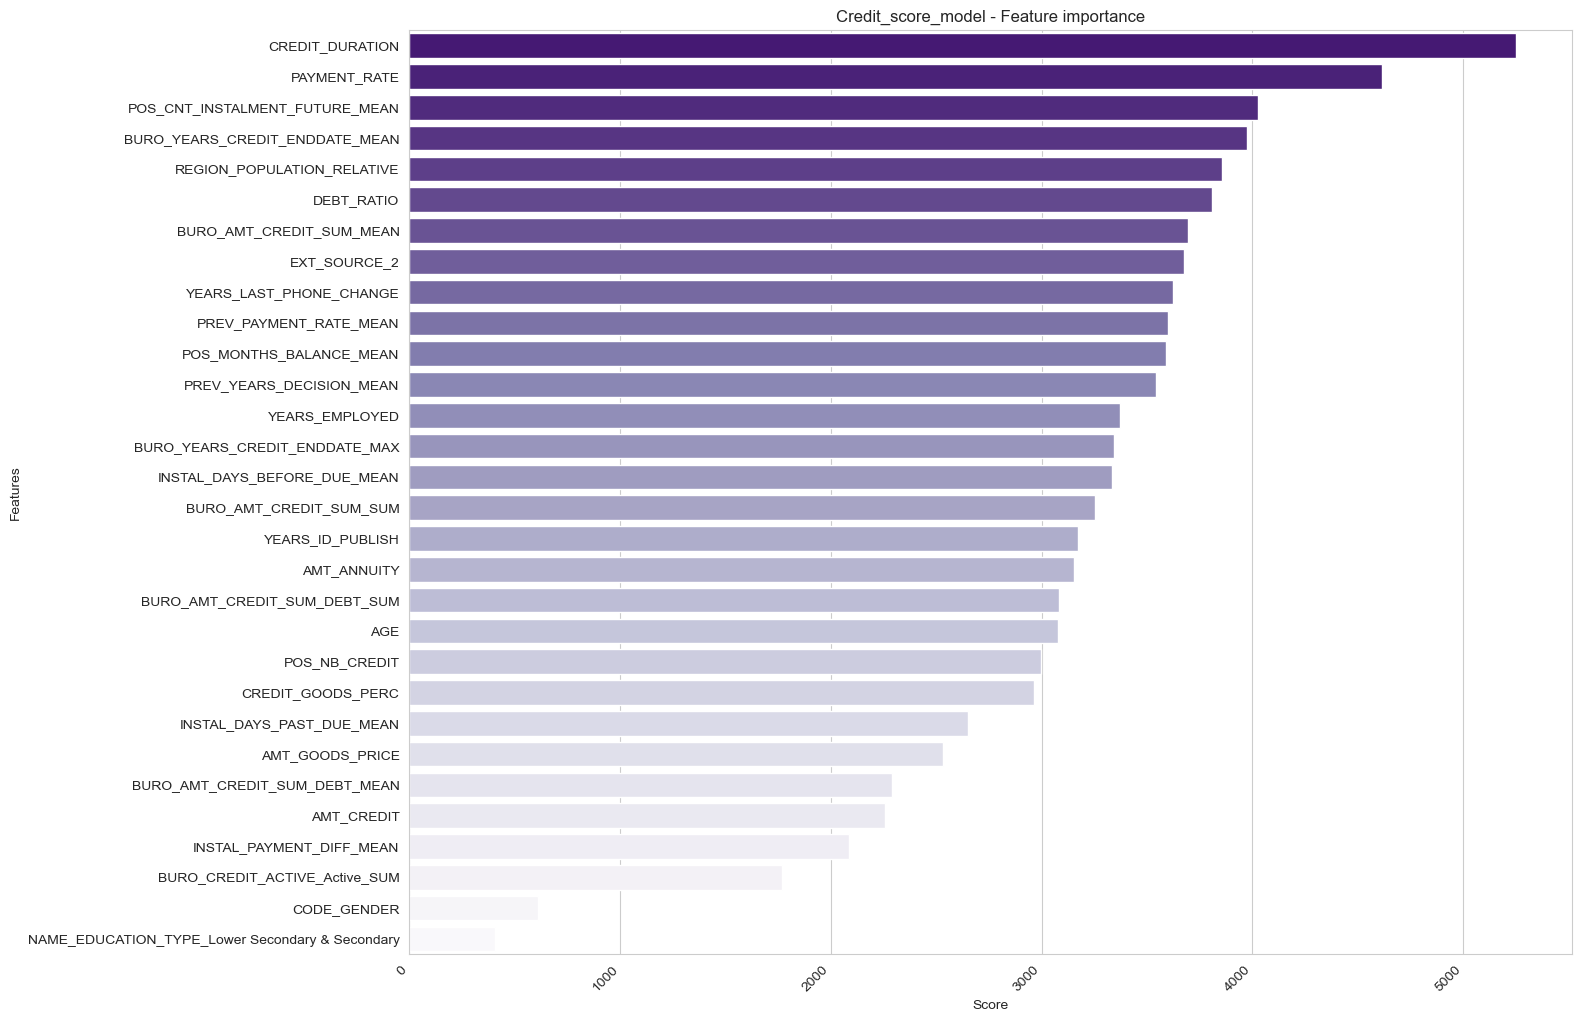

In [226]:
plt.figure(figsize=(15,12))
plt.title('Credit_score_model - Feature importance')
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df_credit_score_model, x = 'Score', y = 'Features', palette='Purples_r');

#### Feature importance locale

L’algorithme LIME (en anglais, Local Interpretable Model-agnostic Explanations) est un **modèle local** qui cherche à expliquer la **prédiction d’un individu par analyse de son voisinage**.

LIME a la particularité d’être un modèle :

- **Interprétable**: Il fournit une compréhension qualitative entre les variables d'entrée et la réponse. Les relations entrées-sortie sont faciles à comprendre.
- **Simple localement**: Le modèle est globalement complexe, il faut alors chercher des réponses localement plus simples.
- **Agnostique**: Il est capable d'expliquer n'importe quel modèle de machine learning.

Pour ce faire :

- 1ère étape : l’algorithme LIME génère des **nouvelles données**, dans un voisinage proche de l’individu à expliquer.
- 2ème étape : LIME **entraîne un modèle transparent** sur les prédictions du modèle « boîte noire » complexe qu’on cherche à interpréter. Il apprend ainsi à l’aide d’un modèle simple et donc interprétable (par exemple, une régression logistique ou un arbre de décision).

Le modèle transparent joue donc le rôle de modèle de substitut pour interpréter les résultats du modèle complexe d’origine.

Le principal inconvénient de la méthode LIME est lié à son fonctionnement local. Et, LIME ne **permet pas de généraliser l’interprétabilité issue du modèle local à un niveau plus global**.

Avantages:

- **Facile à interpréter**
- **Flexibilité sur les features utilisées**

Inconvénients:

- **Biais** dû à une hypothèse de non-corrélation entre features ce qui peut produire des combinaisons de valeurs aberrantes
- **Résultats peuvent varier** selon l'échantillonnage


Le module lime_tabular possède une classe nommée LimeTabularExplainer qui prend en entrée des données d'entrainement et génère un objet explicatif qui peut ensuite être utilisé pour expliquer une prédiction individuelle. Ci-dessous une liste des paramètres importants de la classe LimeTabularExplainer.

- **training_data** - échantillons (tableau numpy 2D) qui ont été utilisés pour former le modèle
- **mode** - classification - Valeur par défaut ou régression
- **training_labels** - Accepte une liste d'étiquettes des données d'entrainement.
- **feature_names** - Accepte une liste de noms de caractéristiques des données.
- **categorical_features** - Accepte une liste d'indices (par exemple [1,4,5,6]) dans les données d'apprentissage qui représentent des caractéristiques catégorielles.
- **categorical_names** - Il accepte le mappage (dict) d'un nombre entier à une liste de noms. Le mappage contiendra des informations sur toutes les valeurs possibles dans une colonne catégorielle particulière. La liste categorical_names[x][y] pointera vers la yième valeur de la colonne avec l'index x dans l'ensemble de données.
- **class_names** - Accepte une liste de noms de classes pour les tâches de classification.
- **feature_selection** - Accepte une liste des valeurs ci-dessous pour la sélection des caractéristiques lors de la sélection de la m-meilleure caractéristique comme décrit dans le fonctionnement interne de LIME précédemment: forward_selection, chemin_lasso, none, auto
- **random_state** - Il accepte un entier ou un objet np.RandomState spécifiant un état aléatoire afin que nous puissions reproduire les mêmes résultats chaque fois que nous relançons le processus.

https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

Les objets **pipeline n'étant pas pris en compte dans Lime**, nous preprocesserons les données en amont:

In [229]:
# Preprocessing des features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[feat_lgb30])
X_test_scaled = scaler.transform(X_test[feat_lgb30])

In [230]:
# Modèle LightGBM retenu non intégré dans un objet pipeline
credit_score_model_LIME = LGBMClassifier(n_estimators = 31204,
                                         num_leaves = 4,
                                         min_child_samples = 3,
                                         learning_rate = 0.009033979476164342,
                                         log_max_bin = 10,
                                         colsample_bytree = 0.5393339924944204, 
                                         reg_alpha = 15.800090067239827,
                                         reg_lambda = 34.82471227276953,
                                         random_state = 42,
                                         class_weight='balanced')

credit_score_model_LIME.fit(X_train_scaled, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.5393339924944204,
               learning_rate=0.009033979476164342, log_max_bin=10,
               min_child_samples=3, n_estimators=31204, num_leaves=4,
               random_state=42, reg_alpha=15.800090067239827,
               reg_lambda=34.82471227276953)

In [231]:
# Sauvegarde du modèle sur le disque
dump(credit_score_model_LIME, open('credit_score_model_LIME.sav', 'wb'))

Nous allons créer l'objet **LimeTabularExplainer** en lui passant les **données d'entrainement après preprocessing**, le mode (**classification**), les **noms des features** en affectant un entier au random state pour pouvoir reproduire les résultats.

In [232]:
# Création de l'objet LimeTabularExplainer basé sur les données d'entrainement
explainer = lime_tabular.LimeTabularExplainer(X_train_scaled, 
                                              mode = "classification", 
                                              feature_names = feat_lgb30,
                                              random_state = 42)
explainer

Nous allons ensuite **choisir un client de manière aléatoire dans les données de test** et appeler la méthode explain_instance() sur l'objet explainer. Nous lui fournirons en entrée l'**ID du client** et la méthode predict_proba() du LightGBM. Ces étapes vont générer un shéma d'explication montrant la prédiction, un diagramme à barres de la contribution des caractéristiques et un tableau avec les valeurs réelles des caractéristiques qui ont contribué à la prédiction.

In [234]:
idx = random.randint(1, X_test.shape[0])
idx = 25166

Ci-dessous, nous passons un échantillon aléatoire pris dans l'ensemble de données de test, le modèle qui effectuera la prédiction et le nombre de features conservées.

In [235]:
explanation = explainer.explain_instance(X_test_scaled[idx], 
                                         credit_score_model_LIME.predict_proba)
explanation

L'explainer possède une méthode nommée **show_in_notebook()** qui explique **comment nous sommes arrivés à une prédiction particulière basée sur la contribution des caractéristiques**.

En dessous, la figure HTML nous montre la valeur prédite réelle (0 = non défaillant et 1 = défaillant) et son intervalle de confiance, un diagramme à barres montrant les poids de la contribution des caractéristiques à cette prédiction, et un tableau montrant les valeurs réelles des caractéristiques.

A titre d'exemple, un LargestPropertyUseTypeGFA > 0.02 aura une influence positive sur le CO2 prédit (production plus importante de CO2) alors qu'un LargestPropertyUseType qui n'est pas un Pre_School/Daycare aura une influence négative (production moins importante de CO2).

In [236]:
print("Prediction : ", credit_score_model_LIME.predict(X_test_scaled[idx].reshape(1,-1)))
print("Actual :     ", y_test.iloc[idx])

explanation.show_in_notebook()

Prediction :  [0]
Actual :      0


C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\lightgbm\basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


In [240]:
X_test

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                                                                                                                                                                                                                                                             
337757             157500.00   797557.50     26487.00        688500.00                        0.02               1                0           0             2.00                     2                            2                       11                           0                           0   
405321             221400.00   247500.00      9814.50        247500.00                        0.02               1                0           0             2.00                     2                            2                       13                           0                           0   
142233             360000.00   521136.00     54855.00        495000.00                        0.05               1                0           0             2.00                     1                            1                       14                           0                           0   
443286             675000.00   675000.00     33750.00        675000.00                        0.03               1                0           0             3.00                     1                            1                       14                           0                           0   
331779             270000.00   254700.00     24939.00        225000.00                        0.05               1                0           0             1.00                     1                            1                       12                           0                           0   
...                      ...         ...          ...              ...                         ...             ...              ...         ...              ...                   ...                          ...                      ...                         ...                         ...   
423085             225000.00   202500.00     24030.00        202500.00                        0.03               1                0           0             2.00                     2                            2                       13                           0                           0   
437346             315000.00  1288350.00     37800.00       1125000.00                        0.02               1                0           0             2.00                     3                            2                        7                           0                           0   
364806             202500.00   269550.00     23188.50        225000.00                        0.03               1                1           1             1.00                     2                            2                       14                           0                           0   
333649             157500.00   942300.00     36643.50        675000.00                        0.04               1                0           0             1.00                     2                            2                       11                           0                           0   
386357             103500.00  1022022.00     43299.00        913500.00                        0.03               1                0           0             2.00                     2                            2                       12                           0                           0   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  FLAG_DOCUMEN

### Analyse du data drift <a class="anchor" id="datadrift"></a>

### A supprimer

In [ ]:
#EXPERIMENT_NAME = "mlflow-default-risk"
#EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

start_Dummy = time.time()
model = DummyClassifier()

# Sélection des hyperparamètres
params = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
scoring = make_scorer(recall_score)

best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                                xtrain = X_train,
                                                                ytrain = y_train,
                                                                params = params,
                                                                scoring = scoring)


duration_Dummy = time.time() - start_Dummy
    
# Evaluation du modèle
(recall, precision, accuracy, auc) = eval_metrics(best_model = best_model_Dummy,
                                                    xtest = X_test,
                                                    ytest = y_test)
    
print(f"DummyClassifier Model with param strategy = {best_params_Dummy['strategy']}")
print()
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Train time: {duration_Dummy:.2f}")

# Start MLflow
with mlflow.start_run() as run:
#with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME) as run:
    
    # Run id
    RUN_ID = run.info.run_id
    
    # log des paramètres et scores à chaque fois que le modèle est lancé
    mlflow.log_param("strategy", best_params_Dummy['strategy'])
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("Tps_entrainement", duration_Dummy)
    
    mlflow.sklearn.log_model(best_model_Dummy, "dummyclassifier")

<div class="alert alert-block alert-success">
    <p>•	Finir la partie exploration et la transformation et choix des features 
•	Créer un environnement MLFlow permettant le tracking lors de l’entraînement des modèles, la visualisation et la comparaison via l’UI de MLFlow, ainsi que le stockage de manière centralisée des modèles.
o	Il faut au minimum le tracking des scores (scores métier, AUC), des hyperparamètres, des temps de traitement de fit et de prédiction, ainsi que le stockage de graphiques (ROC curve) et des modèles
•	Une fonction de tracking de logs 

Bonus (je te le mets pour que tu l'aies en tête mais je n'attends pas que tu le fasse tout de suite) :
•	Avant de construire les modèles, réfléchir à la fonction de coût métier : 
o	La problématique « métier » est de prendre en compte qu’un faux positifs (crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte.
o	Le score “métier” consiste à calculer une fonction de coût métier de type 10*FN + FP 
o	Les modèles et leur hyperparamètres seront optimisés via un GridSearchCV ou équivalent sur ce score, faire aussi l’accuracy ou l’AUC comme élément de comparaison (le garder en référence)
</p>
</div>

<div class="alert alert-block alert-warning">
    <p>Suppression des variables avec 30% ou plus de NaN</p>
</div>

In [ ]:
for b in range(1,200,10):
    y_pred = lgb.predict(X_test)
    score = fbeta_score(y_true = y_test,
                        y_pred = y_pred,
                        beta = b)
    print(f'Score avec beta = {b}: {round(score,4)}')

##### Démarche MLOps

In [ ]:
!mlflow --version

In [ ]:
# Création du tracking cad où MLFlow sauvegarde les runs
mlflow.set_tracking_uri("file:///Users/milie/01_PYTHON/4. OPEN_CLASSROOMS/07_PROJET_7/mlruns")

# Création d'un experiment
experiment_id = mlflow.create_experiment("Training binary classifier")


with mlflow.start_run(experiment_id = experiment_id):
    start_Dummy = time.time()
    model = DummyClassifier()

    # Sélection des hyperparamètres
    params = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
    scoring = make_scorer(recall_score)

    best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                                    xtrain = X_train,
                                                                    ytrain = y_train,
                                                                    params = params,
                                                                    scoring = scoring)


    duration_Dummy = time.time() - start_Dummy
    
    # Evaluation du modèle
    (recall, precision, accuracy, auc) = eval_metrics(best_model = best_model_Dummy,
                                                      xtest = X_test,
                                                      ytest = y_test)
    
    print(f"DummyClassifier Model with param strategy = {best_params_Dummy['strategy']}")
    print()
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Train time: {duration_Dummy:.2f}")
    
    # log des paramètres et scores à chaque fois que le modèle est lancé
    mlflow.log_param("strategy", best_params_Dummy['strategy'])
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("Tps_entrainement", duration_Dummy)
    
    mlflow.sklearn.log_model(best_model_Dummy, "dummyclassifier")